In [20]:
-- option settings
local rootDir = '../'
local date = '1113'
-- local dateLoad = '1107'
local dateLoad = '1108'
-- local itLoadFix = '_iteration_80000'
local itLoadFix = ''
local align = "_nowarp"
local modelName = 'model2_symskip_nngraph2_deeper'
local epochTest = '400' -- don't know what this means

local dataFolder = rootDir.."data/training_augumented_all_nostab"..align
local modelDir = rootDir.."models/"..modelName..".lua"
local paramLoadFolder = rootDir..'logs/'..dateLoad..'_'..modelName..align
local paramSaveFolder =rootDir..'logs/'..date..'_'..modelName..align

opt = {}
opt.seed = 251
opt.model = modelDir
opt.model_param_load = paramLoadFolder..'/param_epoch_'..epochTest..itLoadFix..'.t7' 
opt.bn_meanstd_load = paramLoadFolder..'/bn_meanvar_epoch_'..epochTest..itLoadFix..'.t7'
opt.optimstate_load = paramLoadFolder..'/optimstate_epoch_'..epochTest..itLoadFix..'.t7'
opt.data_root = dataFolder
opt.trainset_size = 61 
opt.batch_size = 8 
opt.it_max = 79810
opt.model_param = paramSaveFolder..'/param_epoch_'..epochTest 
opt.bn_meanstd = paramSaveFolder..'/bn_meanvar_epoch_'..epochTest 
opt.optimstate = paramSaveFolder..'/optimstate_epoch_'..epochTest  
opt.save_every = 1000 
-- opt.log = paramSaveFolder..'/train.log' 

In [14]:
-- scan batches
require("lfs")

alignFolder = opt.data_root
print(alignFolder)
print(string.format('scanning videos from %s',alignFolder))
videoNames = {}
batchDirs = {}
local iVideos = 0;
local nBatches = 0;
for videoName in lfs.dir(alignFolder) do
    if videoName ~= "." and videoName ~= ".." then
--         print(videoName)
        iVideos = iVideos+1
        videoNames[iVideos] = videoName
        batchDirs[videoName] = {};
        local videoFolder = paths.concat(alignFolder,videoName);
        for batchName in lfs.dir(videoFolder) do
            if batchName ~= "." and batchName ~= ".." then
                table.insert(batchDirs[videoName],
                    paths.concat(videoFolder,batchName))
--                 print(batchName)
            end
        end
        table.sort(batchDirs[videoName])
        nBatches = nBatches + #batchDirs[videoName]
    end
end
table.sort(videoNames)
print(string.format('Found %d videos and %d batches',#videoNames,nBatches))


../data/training_augumented_all_nostab_nowarp	
scanning videos from ../data/training_augumented_all_nostab_nowarp	


Found 71 videos and 33540 batches	


In [15]:
package.path = package.path .. ";../models/model2_symskip_nngraph2_deeper.lua"
print(package.path)

/home/omnisky/.luarocks/share/lua/5.1/?.lua;/home/omnisky/.luarocks/share/lua/5.1/?/init.lua;/home/omnisky/torch/install/share/lua/5.1/?.lua;/home/omnisky/torch/install/share/lua/5.1/?/init.lua;./?.lua;/home/omnisky/torch/install/share/luajit-2.1.0-beta1/?.lua;/usr/local/share/lua/5.1/?.lua;/usr/local/share/lua/5.1/?/init.lua;../models/model2_symskip_nngraph2_deeper.lua;../models/model2_symskip_nngraph2_deeper.lua	


In [16]:
-- split datasets (videoNames) into trainset and validset
local trainsetSize = math.min(opt.trainset_size,#videoNames)

math.randomseed(opt.seed) 
local name2weight = {}
for iVideo,videoName in ipairs(videoNames) do
    name2weight[videoName] = math.random()
end
table.sort(videoNames,function(a,b) return name2weight[a]<name2weight[b] end)
trainset={}
validset={}
for iVideo,videoName in ipairs(videoNames) do
    if(iVideo<=trainsetSize) then
        table.insert(trainset,videoName)
    else
        table.insert(validset,videoName)
    end
end
print(string.format('Found %d trainsets and %d validsets',#trainset,#validset))


Found 61 trainsets and 10 validsets	


  64
  15
 128
 128
[torch.LongStorage of size 4]

  64
   3
 128
 128
[torch.LongStorage of size 4]

showing patchInput	


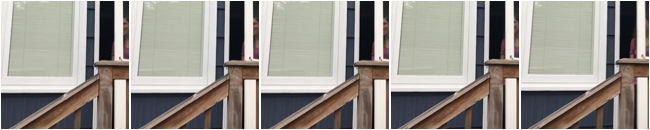

showing patchGT	


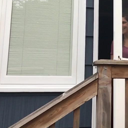

In [17]:
-- load and show first batch
require 'math'
matio = require 'matio'

function loadBatch(videoNames,iVideo,iBatch)
    sampleDir = batchDirs[videoNames[iVideo] ][iBatch]
--     print('loading batch ' .. sampleDir)
    batchSample = matio.load(sampleDir)
    return batchSample.batchInputTorch, batchSample.batchGTTorch
end

batchInputSample,batchGTSample = loadBatch(videoNames,1,1);
print(#batchInputSample)
print(#batchGTSample)


function showSampleBatch(batchInput,batchGT)
    print('showing patchInput')
    local patchInputSample = batchInput[1]
    itorch.image(patchInputSample:contiguous():view(5,3,128,128))
    
    print('showing patchGT')
    local patchGTSample = batchGT[1]
    itorch.image(patchGTSample)
end
showSampleBatch(batchInputSample,batchGTSample)

  64
  15
 128
 128
[torch.LongStorage of size 4]

  64
   3
 128
 128
[torch.LongStorage of size 4]

showing patchInput	


showing patchGT	


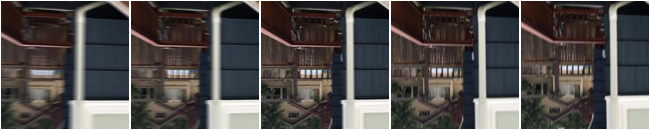

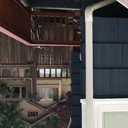

In [18]:
-- load and view random batch sample
function loadRandomBatchFrom(videoNames,batchSize)
    local iVideo = math.random(#videoNames)
    local iBatch = math.random(#batchDirs[videoNames[iVideo] ])
    local sampleDir = batchDirs[videoNames[iVideo] ][iBatch]
    local batchSample = matio.load(sampleDir)

    local batchInputRaw,batchGTRaw = batchSample.batchInputTorch, batchSample.batchGTTorch

    batchSize = batchSize or batchInputRaw:size(1)
    if batchSize - batchInputRaw:size(1) ~= 0 then
        local shuffle = torch.randperm(batchInputRaw:size(1))
        batchInput = torch.zeros(batchSize,batchInputRaw:size(2),batchInputRaw:size(3),batchInputRaw:size(4))
        batchGT = torch.zeros(batchSize,batchGTRaw:size(2),batchGTRaw:size(3),batchGTRaw:size(4))
        for i=1,batchSize do
            batchInput[i] = batchInputRaw[shuffle[i] ]
            batchGT[i] = batchGTRaw[shuffle[i] ]
        end
    else
        batchInput = batchInputRaw
        batchGT = batchGTRaw
    end

    return batchInput, batchGT
end

math.randomseed(251) 
batchInput,batchGT = loadRandomBatchFrom({videoNames[1]})
print(#batchInput)
print(#batchGT)

showSampleBatch(batchInput,batchGT)

In [7]:
-- load model
require 'torch'
require 'cunn'
require 'cutorch'
require 'nn'
require 'optim'

modelDir = opt.model
print(string.format( "Loading model %s",modelDir ))
require(modelDir)
net = create_model()
net = net:cuda()
print("Model loaded")

Loading model ../models/model2_symskip_nngraph2_deeper.lua	


Model loaded	


In [8]:
-- params setting
max_intensity = 255
batchSize = opt.batch_size
decayFrom = 24000
decayEvery = 8000
decayRate = 0.5
itMax = opt.it_max
lrMin = 1e-6

print(string.format( "Params setting: max_intensity = %f",max_intensity ))
print(string.format( "                    batchSize = %d",batchSize ))
print(string.format( "                    decayFrom = %d",decayFrom ))
print(string.format( "                   decayEvery = %d",decayEvery ))
print(string.format( "                    decayRate = %f",decayRate ))
print(string.format( "                        itMax = %d",itMax ))
print(string.format( "                        lrMin = %f",lrMin ))

criterion = nn.MSECriterion()
criterion = criterion:cuda()

params, gradParams = net:getParameters()

paramsSaveDir = opt.model_param
bn_meanvarSaveDir = opt.bn_meanstd
optimstateSaveDir = opt.optimstate
saveEvery = opt.save_every

Params setting: max_intensity = 255.000000	
                    batchSize = 8	
                    decayFrom = 24000	
                   decayEvery = 8000	
                    decayRate = 0.500000	
                        itMax = 79810	
                        lrMin = 0.000001	


In [88]:
-- load params
paramsLoadDir = opt.model_param_load
bn_meanvarLoadDir = opt.bn_meanstd_load
optimstateLoadDir = opt.optimstate_load

function loadParams()
    print(string.format(
    "Loading params from: \nparamsLoadDir: %s \nbn_meanvarLoadDir: %s \noptimstateLoadDir: %s ", 
    paramsLoadDir,bn_meanvarLoadDir,optimstateLoadDir))
    if not pcall(
            function()
                local paramsSave = torch.load(paramsLoadDir)
                local bn_meanvarSave = torch.load(bn_meanvarLoadDir)
                optimstateSave = torch.load(optimstateLoadDir)

                params:copy(paramsSave)
                local bn_mean, bn_std = table.unpack(bn_meanvarSave)
                for k,v in pairs(net:findModules('nn.SpatialBatchNormalization')) do
                    v.running_mean:copy(bn_mean[k])
                    v.running_var:copy(bn_std[k])
                end
            end) 
    then
        print('No params to load or wrong dir!\n')
    end
    
    optimConfig = optimstateSave or {}
    optimConfig.learningRate = optimConfig.learningRate or 0.005
    optimConfig.weightDecay = optimConfig.weightDecay or 0
    optimConfig.beta1 = optimConfig.beta1 or 0.9
    optimConfig.beta2 = optimConfig.beta2 or 0.999
    optimConfig.epsilon = optimConfig.epsilon or 1e-8
    print('optimConfig = ')
    print(optimConfig)
    optimConfig.t = optimConfig.t or 0
    itBegin = optimConfig.t+1
end

loadParams()

Loading params from: 
paramsLoadDir: ../logs/1108_model2_symskip_nngraph2_deeper_nowarp/param_epoch_400.t7 
bn_meanvarLoadDir: ../logs/1108_model2_symskip_nngraph2_deeper_nowarp/bn_meanvar_epoch_400.t7 
optimstateLoadDir: ../logs/1108_model2_symskip_nngraph2_deeper_nowarp/optimstate_epoch_400.t7 	


optimConfig = 	
{
  v : CudaTensor - size: 15305291
  beta1 : 0.9
  learningRate : 0.005
  beta2 : 0.999
  denom : CudaTensor - size: 15305291
  epsilon : 1e-08
  weightDecay : 0
  t : 79800
  m : CudaTensor - size: 15305291
}


In [19]:
-- save params
function saveParams(it)
    local paramsSaveDir = paramsSaveDir..'_iteration_'..it..'.t7'
    local bn_meanvarSaveDir = bn_meanvarSaveDir..'_iteration_'..it..'.t7'
    local optimstateSaveDir = optimstateSaveDir..'_iteration_'..it..'.t7'
    print(string.format(
        "Saving params to: \nparamsSaveDir: %s \nbn_meanvarSaveDir: %s \noptimstateSaveDir: %s ", 
        paramsSaveDir,bn_meanvarSaveDir,optimstateSaveDir))
    torch.save(paramsSaveDir,params)
    local bn_mean = {}
    local bn_std = {}
    for k,v in pairs(net:findModules('nn.SpatialBatchNormalization')) do
        table.insert(bn_mean,v.running_mean)
        table.insert(bn_std,v.running_var)
    end
    local bn_meanvar = {bn_mean,bn_std}
    torch.save(bn_meanvarSaveDir,bn_meanvar)
    torch.save(optimstateSaveDir,optimConfig)
    print(optimConfig)
end

In [126]:
-- iteration funtion
local function feval(params)
    gradParams:zero()

    local batchInput,batchGT = loadRandomBatchFrom(trainset，batchSize)

    batchInput = batchInput:float():div(max_intensity):cuda()
    batchGT = batchGT:float():div(max_intensity):cuda()
        
    local predict = net:forward(batchInput)
    loss = criterion:forward(predict, batchGT)
    local dloss_dpredict = criterion:backward(predict,batchGT)
    local gradInput = net:backward(batchInput, dloss_dpredict)
        
    return loss, gradParams
end


-- Log results to files
if opt.log then
    print('logging to: '..opt.log)
    trainLogger = optim.Logger(opt.log)
    trainLogger:setNames{'loss'}
end

In [11]:
-- train
-- at least 12 GB video memory required for batch size 64
math.randomseed(opt.seed) 
local tic = sys.clock()
net:training() -- set train = true
for it = itBegin,itMax do
    if it>=decayFrom and (it-decayFrom)%decayEvery==0 then
        optimConfig.learningRate = optimConfig.learningRate*decayRate
    end
    if optimConfig.learningRate<lrMin then
        optimConfig.learningRate = lrMin
    end

    optim.adam(feval,params,optimConfig)
    
    local toc = sys.clock()
    speed = 1/(toc-tic)
    avgSpeed = avgSpeed or speed
    avgSpeed = 0.1*speed+0.9*avgSpeed
    timeLeft = (itMax-it)/avgSpeed
    toc = tic
    tic = sys.clock()
    timeLeftMin = timeLeft/60
    print(string.format(
            'it: %d, loss: %f, lr: %f, spd: %.2f it/s, avgSpd: %.2f it/s, left: %d h %.1f min',
            it,loss,optimConfig.learningRate,speed,avgSpeed,timeLeftMin/60,timeLeftMin%60))
    
    -- update logger/plot
    if trainLogger then
        trainLogger:add{loss}
        trainLogger:style{'-'}
        trainLogger:plot()
    end

--     if it%opt.save_every == 0 or it == itMax then 
--         saveParams(it)
--     end
end

it: 79801, loss: 0.008127, lr: 0.005000, spd: 1.19 it/s, avgSpd: 1.19 it/s, left: 0 h 0.1 min	


it: 79802, loss: 0.001575, lr: 0.005000, spd: 1.84 it/s, avgSpd: 1.25 it/s, left: 0 h 0.1 min	


it: 79803, loss: 0.002611, lr: 0.005000, spd: 1.72 it/s, avgSpd: 1.30 it/s, left: 0 h 0.1 min	


it: 79804, loss: 0.003665, lr: 0.005000, spd: 1.73 it/s, avgSpd: 1.34 it/s, left: 0 h 0.1 min	


it: 79805, loss: 0.003004, lr: 0.005000, spd: 1.95 it/s, avgSpd: 1.40 it/s, left: 0 h 0.1 min	


it: 79806, loss: 0.002644, lr: 0.005000, spd: 1.81 it/s, avgSpd: 1.44 it/s, left: 0 h 0.0 min	


it: 79807, loss: 0.003786, lr: 0.005000, spd: 1.83 it/s, avgSpd: 1.48 it/s, left: 0 h 0.0 min	


it: 79808, loss: 0.002538, lr: 0.005000, spd: 1.92 it/s, avgSpd: 1.53 it/s, left: 0 h 0.0 min	


it: 79809, loss: 0.004308, lr: 0.005000, spd: 1.71 it/s, avgSpd: 1.55 it/s, left: 0 h 0.0 min	


it: 79810, loss: 0.000868, lr: 0.005000, spd: 1.81 it/s, avgSpd: 1.57 it/s, left: 0 h 0.0 min	


In [29]:
-- save params
saveParams(itMax)

Saving params to: 
paramsSaveDir: ../logs/1112_model2_symskip_nngraph2_deeper_nowarp/param_epoch_400_iteration_79810.t7 
bn_meanvarSaveDir: ../logs/1112_model2_symskip_nngraph2_deeper_nowarp/bn_meanvar_epoch_400_iteration_79810.t7 
optimstateSaveDir: ../logs/1112_model2_symskip_nngraph2_deeper_nowarp/optimstate_epoch_400_iteration_79810.t7 	


{
  v : CudaTensor - size: 15305291
  beta1 : 0.9
  learningRate : 0.005
  beta2 : 0.999
  denom : CudaTensor - size: 15305291
  epsilon : 1e-08
  weightDecay : 0
  t : 79800
  m : CudaTensor - size: 15305291
}



In [40]:
-- load params
loadParams()

Loading params from: 
paramsLoadDir: ../logs/1107_model2_symskip_nngraph2_deeper_nowarp/param_epoch_400_iteration_80000.t7 
bn_meanvarLoadDir: ../logs/1107_model2_symskip_nngraph2_deeper_nowarp/bn_meanvar_epoch_400_iteration_80000.t7 
optimstateLoadDir: ../logs/1107_model2_symskip_nngraph2_deeper_nowarp/optimstate_epoch_400_iteration_80000.t7 	


optimConfig = 	
{
  v : CudaTensor - size: 15305291
  m : CudaTensor - size: 15305291
  learningRate : 1.953125e-05
  t : 80000
  denom : CudaTensor - size: 15305291
  epsilon : 1e-08
  weightDecay : 0
  beta2 : 0.999
  beta1 : 0.9
}



In [21]:
-- test net

-- load batch
local lossTrainset = 0
local nPatches = 0
local nPatchesEveryMax = 1

net:evaluate() -- set train = false
for iVideo,videoName in ipairs(validset) do
--     for iBatch = 1,#batchDirs[videoName] do
    for iBatch = 1,nPatchesEveryMax do
        local batchInput,batchGT = loadBatch(validset,iVideo,iBatch)
        batchInput = batchInput[{{1,batchSize},{},{},{}}]
        batchGT = batchGT[{{1,batchSize},{},{},{}}]
        batchInput = batchInput:float():div(max_intensity):cuda()
        batchGT = batchGT:float():div(max_intensity):cuda()

        local predict = net:forward(batchInput)
        lossTrainset = lossTrainset+criterion:forward(predict, batchGT)
        nPatches = nPatches+1
        print(string.format('%d patches done',nPatches))
    end
end
lossTrainset = lossTrainset/nPatches
print(string.format('final test loss: %f',lossTrainset))

1 patches done	


2 patches done	


3 patches done	


4 patches done	


5 patches done	


6 patches done	


7 patches done	


8 patches done	


9 patches done	


10 patches done	
final test loss: 0.064256	


showing patchInput	


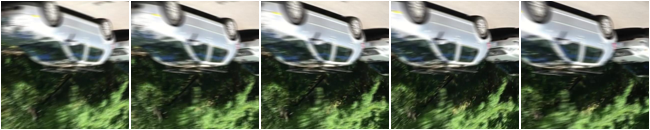

showing patchGT	


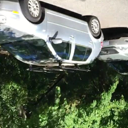

showing net output	


0.00084024836542085	


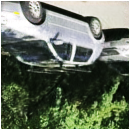

In [27]:
print('showing patchInput')
batchInputSample,batchGTSample = loadBatch(trainset,2,12);
patchInput = batchInputSample[{{1},{},{},{}}]
itorch.image(patchInput:contiguous():view(5,3,128,128))

print('showing patchGT')
-- show example output
patchGT = batchGTSample[1]:float():div(max_intensity):cuda()
itorch.image(patchGT)

print('showing net output')
patchInput = patchInput:float():div(max_intensity):cuda()
net:evaluate() -- set train = false
local predict = net:forward(patchInput)
local loss = criterion:forward(predict,patchGT)
print(loss)
predict = predict:mul(max_intensity):byte()
itorch.image(predict)


In [26]:
-- try overfiting a patch
local function fevalOverfit(params)
    gradParams:zero()
        
    local predict = net:forward(patchInput)
    loss = criterion:forward(predict, patchGT)
    local dloss_dpredict = criterion:backward(predict,patchGT)
    local gradInput = net:backward(patchInput, dloss_dpredict)
        
    return loss, gradParams
end

-- settings
local decayFrom = 500
local decayEvery = 300
local optimConfig = {}
optimConfig.learningRate =  0.005
optimConfig.weightDecay = 0
optimConfig.beta1 = 0.9
optimConfig.beta2 = 0.999
optimConfig.epsilon = 1e-8
local lrMin = 1e-6
local itMaxOverfit = 1000
local tic = sys.clock()

net:training() -- set train = true
for it = 1,itMaxOverfit do
    if it>=decayFrom and (it-decayFrom)%decayEvery==0 then
        optimConfig.learningRate = optimConfig.learningRate*decayRate
    end
    if optimConfig.learningRate<lrMin then
        optimConfig.learningRate = lrMin
    end

    optim.adam(fevalOverfit,params,optimConfig)
    
    local toc = sys.clock()
    speed = 1/(toc-tic)
    avgSpeed = avgSpeed or speed
    avgSpeed = 0.1*speed+0.9*avgSpeed
    timeLeft = (itMaxOverfit-it)/avgSpeed
    toc = tic
    tic = sys.clock()
    timeLeftMin = timeLeft/60
    print(string.format(
            'it: %d, loss: %f, lr: %f, spd: %.2f it/s, avgSpd: %.2f it/s, left: %d h %.1f min',
            it,loss,optimConfig.learningRate,speed,avgSpeed,timeLeftMin/60,timeLeftMin%60))
end

it: 1, loss: 0.200133, lr: 0.005000, spd: 78.27 it/s, avgSpd: 51.91 it/s, left: 0 h 0.3 min	


it: 2, loss: 0.031334, lr: 0.005000, spd: 45.90 it/s, avgSpd: 51.31 it/s, left: 0 h 0.3 min	


it: 3, loss: 0.056649, lr: 0.005000, spd: 43.55 it/s, avgSpd: 50.53 it/s, left: 0 h 0.3 min	


it: 4, loss: 0.050795, lr: 0.005000, spd: 43.25 it/s, avgSpd: 49.81 it/s, left: 0 h 0.3 min	


it: 5, loss: 0.024986, lr: 0.005000, spd: 43.45 it/s, avgSpd: 49.17 it/s, left: 0 h 0.3 min	


it: 6, loss: 0.009045, lr: 0.005000, spd: 43.86 it/s, avgSpd: 48.64 it/s, left: 0 h 0.3 min	


it: 7, loss: 0.020776, lr: 0.005000, spd: 43.63 it/s, avgSpd: 48.14 it/s, left: 0 h 0.3 min	


it: 8, loss: 0.028588, lr: 0.005000, spd: 42.94 it/s, avgSpd: 47.62 it/s, left: 0 h 0.3 min	


it: 9, loss: 0.017086, lr: 0.005000, spd: 44.66 it/s, avgSpd: 47.32 it/s, left: 0 h 0.3 min	


it: 10, loss: 0.009801, lr: 0.005000, spd: 46.45 it/s, avgSpd: 47.23 it/s, left: 0 h 0.3 min	


it: 11, loss: 0.012086, lr: 0.005000, spd: 46.22 it/s, avgSpd: 47.13 it/s, left: 0 h 0.3 min	


it: 12, loss: 0.016736, lr: 0.005000, spd: 46.30 it/s, avgSpd: 47.05 it/s, left: 0 h 0.3 min	


it: 13, loss: 0.018728, lr: 0.005000, spd: 46.11 it/s, avgSpd: 46.96 it/s, left: 0 h 0.4 min	


it: 14, loss: 0.017147, lr: 0.005000, spd: 45.93 it/s, avgSpd: 46.85 it/s, left: 0 h 0.4 min	


it: 15, loss: 0.013514, lr: 0.005000, spd: 46.02 it/s, avgSpd: 46.77 it/s, left: 0 h 0.4 min	


it: 16, loss: 0.010444, lr: 0.005000, spd: 45.88 it/s, avgSpd: 46.68 it/s, left: 0 h 0.4 min	


it: 17, loss: 0.010186, lr: 0.005000, spd: 47.23 it/s, avgSpd: 46.74 it/s, left: 0 h 0.4 min	


it: 18, loss: 0.012543, lr: 0.005000, spd: 48.47 it/s, avgSpd: 46.91 it/s, left: 0 h 0.3 min	


it: 19, loss: 0.013788, lr: 0.005000, spd: 48.35 it/s, avgSpd: 47.05 it/s, left: 0 h 0.3 min	


it: 20, loss: 0.011689, lr: 0.005000, spd: 48.42 it/s, avgSpd: 47.19 it/s, left: 0 h 0.3 min	


it: 21, loss: 0.012079, lr: 0.005000, spd: 48.48 it/s, avgSpd: 47.32 it/s, left: 0 h 0.3 min	


it: 22, loss: 0.010842, lr: 0.005000, spd: 48.16 it/s, avgSpd: 47.40 it/s, left: 0 h 0.3 min	


it: 23, loss: 0.009801, lr: 0.005000, spd: 48.36 it/s, avgSpd: 47.50 it/s, left: 0 h 0.3 min	


it: 24, loss: 0.009984, lr: 0.005000, spd: 48.20 it/s, avgSpd: 47.57 it/s, left: 0 h 0.3 min	


it: 25, loss: 0.010573, lr: 0.005000, spd: 48.19 it/s, avgSpd: 47.63 it/s, left: 0 h 0.3 min	


it: 26, loss: 0.010644, lr: 0.005000, spd: 49.86 it/s, avgSpd: 47.85 it/s, left: 0 h 0.3 min	


it: 27, loss: 0.010208, lr: 0.005000, spd: 49.27 it/s, avgSpd: 48.00 it/s, left: 0 h 0.3 min	


it: 28, loss: 0.009748, lr: 0.005000, spd: 48.95 it/s, avgSpd: 48.09 it/s, left: 0 h 0.3 min	


it: 29, loss: 0.009461, lr: 0.005000, spd: 48.34 it/s, avgSpd: 48.12 it/s, left: 0 h 0.3 min	


it: 30, loss: 0.009398, lr: 0.005000, spd: 48.76 it/s, avgSpd: 48.18 it/s, left: 0 h 0.3 min	


it: 31, loss: 0.009549, lr: 0.005000, spd: 48.89 it/s, avgSpd: 48.25 it/s, left: 0 h 0.3 min	


it: 32, loss: 0.009656, lr: 0.005000, spd: 49.18 it/s, avgSpd: 48.34 it/s, left: 0 h 0.3 min	


it: 33, loss: 0.009549, lr: 0.005000, spd: 48.94 it/s, avgSpd: 48.40 it/s, left: 0 h 0.3 min	


it: 34, loss: 0.009306, lr: 0.005000, spd: 48.65 it/s, avgSpd: 48.43 it/s, left: 0 h 0.3 min	


it: 35, loss: 0.009112, lr: 0.005000, spd: 49.02 it/s, avgSpd: 48.49 it/s, left: 0 h 0.3 min	


it: 36, loss: 0.009093, lr: 0.005000, spd: 45.48 it/s, avgSpd: 48.19 it/s, left: 0 h 0.3 min	


it: 37, loss: 0.009160, lr: 0.005000, spd: 50.77 it/s, avgSpd: 48.44 it/s, left: 0 h 0.3 min	


it: 38, loss: 0.009162, lr: 0.005000, spd: 50.20 it/s, avgSpd: 48.62 it/s, left: 0 h 0.3 min	


it: 39, loss: 0.009054, lr: 0.005000, spd: 49.18 it/s, avgSpd: 48.68 it/s, left: 0 h 0.3 min	


it: 40, loss: 0.008909, lr: 0.005000, spd: 49.33 it/s, avgSpd: 48.74 it/s, left: 0 h 0.3 min	


it: 41, loss: 0.008810, lr: 0.005000, spd: 49.27 it/s, avgSpd: 48.79 it/s, left: 0 h 0.3 min	


it: 42, loss: 0.008791, lr: 0.005000, spd: 49.02 it/s, avgSpd: 48.82 it/s, left: 0 h 0.3 min	


it: 43, loss: 0.008803, lr: 0.005000, spd: 49.34 it/s, avgSpd: 48.87 it/s, left: 0 h 0.3 min	


it: 44, loss: 0.008772, lr: 0.005000, spd: 49.10 it/s, avgSpd: 48.89 it/s, left: 0 h 0.3 min	


it: 45, loss: 0.008682, lr: 0.005000, spd: 49.36 it/s, avgSpd: 48.94 it/s, left: 0 h 0.3 min	


it: 46, loss: 0.008587, lr: 0.005000, spd: 49.18 it/s, avgSpd: 48.96 it/s, left: 0 h 0.3 min	


it: 47, loss: 0.008543, lr: 0.005000, spd: 49.11 it/s, avgSpd: 48.98 it/s, left: 0 h 0.3 min	


it: 48, loss: 0.008532, lr: 0.005000, spd: 49.33 it/s, avgSpd: 49.01 it/s, left: 0 h 0.3 min	


it: 49, loss: 0.008513, lr: 0.005000, spd: 49.32 it/s, avgSpd: 49.04 it/s, left: 0 h 0.3 min	


it: 50, loss: 0.008456, lr: 0.005000, spd: 49.37 it/s, avgSpd: 49.08 it/s, left: 0 h 0.3 min	


it: 51, loss: 0.008380, lr: 0.005000, spd: 48.96 it/s, avgSpd: 49.07 it/s, left: 0 h 0.3 min	


it: 52, loss: 0.008326, lr: 0.005000, spd: 49.70 it/s, avgSpd: 49.13 it/s, left: 0 h 0.3 min	


it: 53, loss: 0.008302, lr: 0.005000, spd: 49.17 it/s, avgSpd: 49.13 it/s, left: 0 h 0.3 min	


it: 54, loss: 0.008281, lr: 0.005000, spd: 49.53 it/s, avgSpd: 49.17 it/s, left: 0 h 0.3 min	


it: 55, loss: 0.008235, lr: 0.005000, spd: 49.25 it/s, avgSpd: 49.18 it/s, left: 0 h 0.3 min	


it: 56, loss: 0.008174, lr: 0.005000, spd: 48.77 it/s, avgSpd: 49.14 it/s, left: 0 h 0.3 min	


it: 57, loss: 0.008127, lr: 0.005000, spd: 49.46 it/s, avgSpd: 49.17 it/s, left: 0 h 0.3 min	


it: 58, loss: 0.008098, lr: 0.005000, spd: 49.49 it/s, avgSpd: 49.20 it/s, left: 0 h 0.3 min	


it: 59, loss: 0.008073, lr: 0.005000, spd: 49.42 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 60, loss: 0.008033, lr: 0.005000, spd: 49.29 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 61, loss: 0.007984, lr: 0.005000, spd: 49.11 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 62, loss: 0.007946, lr: 0.005000, spd: 49.36 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 63, loss: 0.007919, lr: 0.005000, spd: 49.34 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 64, loss: 0.007890, lr: 0.005000, spd: 49.19 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 65, loss: 0.007851, lr: 0.005000, spd: 49.22 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 66, loss: 0.007809, lr: 0.005000, spd: 48.65 it/s, avgSpd: 49.18 it/s, left: 0 h 0.3 min	


it: 67, loss: 0.007776, lr: 0.005000, spd: 49.62 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 68, loss: 0.007747, lr: 0.005000, spd: 49.13 it/s, avgSpd: 49.21 it/s, left: 0 h 0.3 min	


it: 69, loss: 0.007716, lr: 0.005000, spd: 49.38 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 70, loss: 0.007743, lr: 0.005000, spd: 49.25 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 71, loss: 0.007645, lr: 0.005000, spd: 49.11 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 72, loss: 0.007639, lr: 0.005000, spd: 49.55 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 73, loss: 0.007617, lr: 0.005000, spd: 49.28 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 74, loss: 0.007576, lr: 0.005000, spd: 49.08 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 75, loss: 0.007537, lr: 0.005000, spd: 49.36 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 76, loss: 0.007502, lr: 0.005000, spd: 49.06 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 77, loss: 0.007473, lr: 0.005000, spd: 49.38 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 78, loss: 0.007438, lr: 0.005000, spd: 49.25 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 79, loss: 0.007397, lr: 0.005000, spd: 49.30 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 80, loss: 0.007359, lr: 0.005000, spd: 49.60 it/s, avgSpd: 49.29 it/s, left: 0 h 0.3 min	


it: 81, loss: 0.007317, lr: 0.005000, spd: 48.85 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 82, loss: 0.007270, lr: 0.005000, spd: 49.54 it/s, avgSpd: 49.27 it/s, left: 0 h 0.3 min	


it: 83, loss: 0.007217, lr: 0.005000, spd: 49.33 it/s, avgSpd: 49.28 it/s, left: 0 h 0.3 min	


it: 84, loss: 0.007163, lr: 0.005000, spd: 49.12 it/s, avgSpd: 49.26 it/s, left: 0 h 0.3 min	


it: 85, loss: 0.007109, lr: 0.005000, spd: 49.10 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 86, loss: 0.007055, lr: 0.005000, spd: 49.28 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 87, loss: 0.006991, lr: 0.005000, spd: 49.23 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 88, loss: 0.006920, lr: 0.005000, spd: 49.26 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 89, loss: 0.006831, lr: 0.005000, spd: 48.25 it/s, avgSpd: 49.15 it/s, left: 0 h 0.3 min	


it: 90, loss: 0.006735, lr: 0.005000, spd: 49.06 it/s, avgSpd: 49.14 it/s, left: 0 h 0.3 min	


it: 91, loss: 0.006632, lr: 0.005000, spd: 48.71 it/s, avgSpd: 49.10 it/s, left: 0 h 0.3 min	


it: 92, loss: 0.006525, lr: 0.005000, spd: 49.09 it/s, avgSpd: 49.10 it/s, left: 0 h 0.3 min	


it: 93, loss: 0.006410, lr: 0.005000, spd: 49.10 it/s, avgSpd: 49.10 it/s, left: 0 h 0.3 min	


it: 94, loss: 0.006296, lr: 0.005000, spd: 49.52 it/s, avgSpd: 49.14 it/s, left: 0 h 0.3 min	


it: 95, loss: 0.006185, lr: 0.005000, spd: 49.51 it/s, avgSpd: 49.18 it/s, left: 0 h 0.3 min	


it: 96, loss: 0.006076, lr: 0.005000, spd: 49.04 it/s, avgSpd: 49.16 it/s, left: 0 h 0.3 min	


it: 97, loss: 0.005973, lr: 0.005000, spd: 49.12 it/s, avgSpd: 49.16 it/s, left: 0 h 0.3 min	


it: 98, loss: 0.005875, lr: 0.005000, spd: 49.08 it/s, avgSpd: 49.15 it/s, left: 0 h 0.3 min	


it: 99, loss: 0.005778, lr: 0.005000, spd: 49.36 it/s, avgSpd: 49.17 it/s, left: 0 h 0.3 min	


it: 100, loss: 0.005675, lr: 0.005000, spd: 49.30 it/s, avgSpd: 49.18 it/s, left: 0 h 0.3 min	


it: 101, loss: 0.005548, lr: 0.005000, spd: 49.03 it/s, avgSpd: 49.17 it/s, left: 0 h 0.3 min	


it: 102, loss: 0.005413, lr: 0.005000, spd: 49.28 it/s, avgSpd: 49.18 it/s, left: 0 h 0.3 min	


it: 103, loss: 0.005298, lr: 0.005000, spd: 49.33 it/s, avgSpd: 49.19 it/s, left: 0 h 0.3 min	


it: 104, loss: 0.005212, lr: 0.005000, spd: 49.22 it/s, avgSpd: 49.20 it/s, left: 0 h 0.3 min	


it: 105, loss: 0.005156, lr: 0.005000, spd: 49.13 it/s, avgSpd: 49.19 it/s, left: 0 h 0.3 min	


it: 106, loss: 0.005112, lr: 0.005000, spd: 49.26 it/s, avgSpd: 49.20 it/s, left: 0 h 0.3 min	


it: 107, loss: 0.005051, lr: 0.005000, spd: 49.26 it/s, avgSpd: 49.20 it/s, left: 0 h 0.3 min	


it: 108, loss: 0.005000, lr: 0.005000, spd: 49.43 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 109, loss: 0.004936, lr: 0.005000, spd: 49.29 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 110, loss: 0.004858, lr: 0.005000, spd: 49.07 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 111, loss: 0.004801, lr: 0.005000, spd: 49.37 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 112, loss: 0.004757, lr: 0.005000, spd: 49.35 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 113, loss: 0.004671, lr: 0.005000, spd: 49.18 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 114, loss: 0.004617, lr: 0.005000, spd: 49.29 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 115, loss: 0.004567, lr: 0.005000, spd: 48.74 it/s, avgSpd: 49.19 it/s, left: 0 h 0.3 min	


it: 116, loss: 0.004517, lr: 0.005000, spd: 49.45 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 117, loss: 0.004473, lr: 0.005000, spd: 48.48 it/s, avgSpd: 49.14 it/s, left: 0 h 0.3 min	


it: 118, loss: 0.004430, lr: 0.005000, spd: 49.93 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 119, loss: 0.004396, lr: 0.005000, spd: 49.31 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 120, loss: 0.004360, lr: 0.005000, spd: 48.12 it/s, avgSpd: 49.12 it/s, left: 0 h 0.3 min	


it: 121, loss: 0.004332, lr: 0.005000, spd: 49.14 it/s, avgSpd: 49.12 it/s, left: 0 h 0.3 min	


it: 122, loss: 0.004293, lr: 0.005000, spd: 48.94 it/s, avgSpd: 49.10 it/s, left: 0 h 0.3 min	


it: 123, loss: 0.004272, lr: 0.005000, spd: 48.85 it/s, avgSpd: 49.08 it/s, left: 0 h 0.3 min	


it: 124, loss: 0.004243, lr: 0.005000, spd: 48.93 it/s, avgSpd: 49.06 it/s, left: 0 h 0.3 min	


it: 125, loss: 0.004226, lr: 0.005000, spd: 48.71 it/s, avgSpd: 49.03 it/s, left: 0 h 0.3 min	


it: 126, loss: 0.004198, lr: 0.005000, spd: 48.92 it/s, avgSpd: 49.02 it/s, left: 0 h 0.3 min	


it: 127, loss: 0.004177, lr: 0.005000, spd: 47.95 it/s, avgSpd: 48.91 it/s, left: 0 h 0.3 min	


it: 128, loss: 0.004159, lr: 0.005000, spd: 48.70 it/s, avgSpd: 48.89 it/s, left: 0 h 0.3 min	


it: 129, loss: 0.004136, lr: 0.005000, spd: 50.98 it/s, avgSpd: 49.10 it/s, left: 0 h 0.3 min	


it: 130, loss: 0.004119, lr: 0.005000, spd: 49.33 it/s, avgSpd: 49.12 it/s, left: 0 h 0.3 min	


it: 131, loss: 0.004098, lr: 0.005000, spd: 49.35 it/s, avgSpd: 49.15 it/s, left: 0 h 0.3 min	


it: 132, loss: 0.004083, lr: 0.005000, spd: 48.93 it/s, avgSpd: 49.12 it/s, left: 0 h 0.3 min	


it: 133, loss: 0.004061, lr: 0.005000, spd: 49.08 it/s, avgSpd: 49.12 it/s, left: 0 h 0.3 min	


it: 134, loss: 0.004041, lr: 0.005000, spd: 49.52 it/s, avgSpd: 49.16 it/s, left: 0 h 0.3 min	


it: 135, loss: 0.004027, lr: 0.005000, spd: 49.32 it/s, avgSpd: 49.18 it/s, left: 0 h 0.3 min	


it: 136, loss: 0.004007, lr: 0.005000, spd: 49.26 it/s, avgSpd: 49.18 it/s, left: 0 h 0.3 min	


it: 137, loss: 0.003990, lr: 0.005000, spd: 49.28 it/s, avgSpd: 49.19 it/s, left: 0 h 0.3 min	


it: 138, loss: 0.003971, lr: 0.005000, spd: 49.20 it/s, avgSpd: 49.19 it/s, left: 0 h 0.3 min	


it: 139, loss: 0.003956, lr: 0.005000, spd: 49.16 it/s, avgSpd: 49.19 it/s, left: 0 h 0.3 min	


it: 140, loss: 0.003934, lr: 0.005000, spd: 49.04 it/s, avgSpd: 49.18 it/s, left: 0 h 0.3 min	


it: 141, loss: 0.003911, lr: 0.005000, spd: 49.38 it/s, avgSpd: 49.20 it/s, left: 0 h 0.3 min	


it: 142, loss: 0.003891, lr: 0.005000, spd: 49.06 it/s, avgSpd: 49.18 it/s, left: 0 h 0.3 min	


it: 143, loss: 0.003873, lr: 0.005000, spd: 49.22 it/s, avgSpd: 49.19 it/s, left: 0 h 0.3 min	


it: 144, loss: 0.003852, lr: 0.005000, spd: 49.44 it/s, avgSpd: 49.21 it/s, left: 0 h 0.3 min	


it: 145, loss: 0.003832, lr: 0.005000, spd: 49.12 it/s, avgSpd: 49.20 it/s, left: 0 h 0.3 min	


it: 146, loss: 0.003812, lr: 0.005000, spd: 49.38 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 147, loss: 0.003792, lr: 0.005000, spd: 49.04 it/s, avgSpd: 49.20 it/s, left: 0 h 0.3 min	


it: 148, loss: 0.003771, lr: 0.005000, spd: 49.40 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 149, loss: 0.003753, lr: 0.005000, spd: 49.17 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 150, loss: 0.003731, lr: 0.005000, spd: 49.58 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 151, loss: 0.003710, lr: 0.005000, spd: 49.28 it/s, avgSpd: 49.26 it/s, left: 0 h 0.3 min	


it: 152, loss: 0.003690, lr: 0.005000, spd: 49.11 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 153, loss: 0.003666, lr: 0.005000, spd: 49.55 it/s, avgSpd: 49.27 it/s, left: 0 h 0.3 min	


it: 154, loss: 0.003644, lr: 0.005000, spd: 49.12 it/s, avgSpd: 49.26 it/s, left: 0 h 0.3 min	

it: 155, loss: 0.003618, lr: 0.005000, spd: 49.30 it/s, avgSpd: 49.26 it/s, left: 0 h 0.3 min	


it: 156, loss: 0.003593, lr: 0.005000, spd: 49.02 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 157, loss: 0.003578, lr: 0.005000, spd: 49.25 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 158, loss: 0.003542, lr: 0.005000, spd: 49.11 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 159, loss: 0.003506, lr: 0.005000, spd: 49.70 it/s, avgSpd: 49.27 it/s, left: 0 h 0.3 min	


it: 160, loss: 0.003487, lr: 0.005000, spd: 49.24 it/s, avgSpd: 49.27 it/s, left: 0 h 0.3 min	


it: 161, loss: 0.003457, lr: 0.005000, spd: 49.17 it/s, avgSpd: 49.26 it/s, left: 0 h 0.3 min	


it: 162, loss: 0.003440, lr: 0.005000, spd: 49.34 it/s, avgSpd: 49.27 it/s, left: 0 h 0.3 min	


it: 163, loss: 0.003410, lr: 0.005000, spd: 49.21 it/s, avgSpd: 49.26 it/s, left: 0 h 0.3 min	


it: 164, loss: 0.003385, lr: 0.005000, spd: 49.35 it/s, avgSpd: 49.27 it/s, left: 0 h 0.3 min	


it: 165, loss: 0.003385, lr: 0.005000, spd: 49.09 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 166, loss: 0.003382, lr: 0.005000, spd: 49.09 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 167, loss: 0.003361, lr: 0.005000, spd: 49.45 it/s, avgSpd: 49.26 it/s, left: 0 h 0.3 min	


it: 168, loss: 0.003318, lr: 0.005000, spd: 49.25 it/s, avgSpd: 49.26 it/s, left: 0 h 0.3 min	


it: 169, loss: 0.003354, lr: 0.005000, spd: 49.21 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 170, loss: 0.003296, lr: 0.005000, spd: 49.27 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 171, loss: 0.003289, lr: 0.005000, spd: 49.18 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 172, loss: 0.003301, lr: 0.005000, spd: 49.18 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 173, loss: 0.003240, lr: 0.005000, spd: 49.33 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 174, loss: 0.003262, lr: 0.005000, spd: 48.92 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 175, loss: 0.003215, lr: 0.005000, spd: 49.20 it/s, avgSpd: 49.21 it/s, left: 0 h 0.3 min	


it: 176, loss: 0.003237, lr: 0.005000, spd: 49.49 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 177, loss: 0.003195, lr: 0.005000, spd: 49.19 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 178, loss: 0.003180, lr: 0.005000, spd: 48.49 it/s, avgSpd: 49.16 it/s, left: 0 h 0.3 min	


it: 179, loss: 0.003176, lr: 0.005000, spd: 48.49 it/s, avgSpd: 49.09 it/s, left: 0 h 0.3 min	


it: 180, loss: 0.003155, lr: 0.005000, spd: 48.87 it/s, avgSpd: 49.07 it/s, left: 0 h 0.3 min	


it: 181, loss: 0.003147, lr: 0.005000, spd: 49.09 it/s, avgSpd: 49.07 it/s, left: 0 h 0.3 min	


it: 182, loss: 0.003142, lr: 0.005000, spd: 49.78 it/s, avgSpd: 49.14 it/s, left: 0 h 0.3 min	


it: 183, loss: 0.003121, lr: 0.005000, spd: 49.34 it/s, avgSpd: 49.16 it/s, left: 0 h 0.3 min	


it: 184, loss: 0.003106, lr: 0.005000, spd: 48.93 it/s, avgSpd: 49.14 it/s, left: 0 h 0.3 min	


it: 185, loss: 0.003100, lr: 0.005000, spd: 49.10 it/s, avgSpd: 49.14 it/s, left: 0 h 0.3 min	


it: 186, loss: 0.003083, lr: 0.005000, spd: 49.50 it/s, avgSpd: 49.17 it/s, left: 0 h 0.3 min	


it: 187, loss: 0.003096, lr: 0.005000, spd: 49.31 it/s, avgSpd: 49.19 it/s, left: 0 h 0.3 min	


it: 188, loss: 0.003083, lr: 0.005000, spd: 49.19 it/s, avgSpd: 49.19 it/s, left: 0 h 0.3 min	


it: 189, loss: 0.003073, lr: 0.005000, spd: 49.26 it/s, avgSpd: 49.19 it/s, left: 0 h 0.3 min	


it: 190, loss: 0.003056, lr: 0.005000, spd: 49.11 it/s, avgSpd: 49.19 it/s, left: 0 h 0.3 min	


it: 191, loss: 0.003048, lr: 0.005000, spd: 49.39 it/s, avgSpd: 49.21 it/s, left: 0 h 0.3 min	


it: 192, loss: 0.003034, lr: 0.005000, spd: 49.21 it/s, avgSpd: 49.21 it/s, left: 0 h 0.3 min	


it: 193, loss: 0.003029, lr: 0.005000, spd: 49.15 it/s, avgSpd: 49.20 it/s, left: 0 h 0.3 min	


it: 194, loss: 0.003023, lr: 0.005000, spd: 49.44 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 195, loss: 0.003006, lr: 0.005000, spd: 49.29 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 196, loss: 0.002997, lr: 0.005000, spd: 49.23 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 197, loss: 0.003010, lr: 0.005000, spd: 49.31 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 198, loss: 0.003002, lr: 0.005000, spd: 49.38 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 199, loss: 0.002987, lr: 0.005000, spd: 49.16 it/s, avgSpd: 49.24 it/s, left: 0 h 0.3 min	


it: 200, loss: 0.002968, lr: 0.005000, spd: 49.26 it/s, avgSpd: 49.25 it/s, left: 0 h 0.3 min	


it: 201, loss: 0.002974, lr: 0.005000, spd: 48.92 it/s, avgSpd: 49.21 it/s, left: 0 h 0.3 min	


it: 202, loss: 0.002980, lr: 0.005000, spd: 49.29 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 203, loss: 0.002967, lr: 0.005000, spd: 49.27 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 204, loss: 0.002941, lr: 0.005000, spd: 49.24 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 205, loss: 0.002927, lr: 0.005000, spd: 49.25 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 206, loss: 0.002923, lr: 0.005000, spd: 49.23 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 207, loss: 0.002910, lr: 0.005000, spd: 49.10 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 208, loss: 0.002901, lr: 0.005000, spd: 49.21 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 209, loss: 0.002894, lr: 0.005000, spd: 49.30 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 210, loss: 0.002880, lr: 0.005000, spd: 49.20 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 211, loss: 0.002877, lr: 0.005000, spd: 49.21 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 212, loss: 0.002901, lr: 0.005000, spd: 49.23 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 213, loss: 0.002890, lr: 0.005000, spd: 49.33 it/s, avgSpd: 49.23 it/s, left: 0 h 0.3 min	


it: 214, loss: 0.002950, lr: 0.005000, spd: 49.13 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 215, loss: 0.002905, lr: 0.005000, spd: 49.21 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 216, loss: 0.002864, lr: 0.005000, spd: 49.05 it/s, avgSpd: 49.20 it/s, left: 0 h 0.3 min	


it: 217, loss: 0.002929, lr: 0.005000, spd: 49.32 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 218, loss: 0.002850, lr: 0.005000, spd: 48.56 it/s, avgSpd: 49.15 it/s, left: 0 h 0.3 min	


it: 219, loss: 0.002988, lr: 0.005000, spd: 49.57 it/s, avgSpd: 49.19 it/s, left: 0 h 0.3 min	


it: 220, loss: 0.003005, lr: 0.005000, spd: 49.43 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 221, loss: 0.002956, lr: 0.005000, spd: 49.14 it/s, avgSpd: 49.21 it/s, left: 0 h 0.3 min	


it: 222, loss: 0.002920, lr: 0.005000, spd: 48.54 it/s, avgSpd: 49.14 it/s, left: 0 h 0.3 min	


it: 223, loss: 0.002946, lr: 0.005000, spd: 48.81 it/s, avgSpd: 49.11 it/s, left: 0 h 0.3 min	


it: 224, loss: 0.002882, lr: 0.005000, spd: 48.92 it/s, avgSpd: 49.09 it/s, left: 0 h 0.3 min	


it: 225, loss: 0.002908, lr: 0.005000, spd: 48.55 it/s, avgSpd: 49.03 it/s, left: 0 h 0.3 min	


it: 226, loss: 0.002904, lr: 0.005000, spd: 49.29 it/s, avgSpd: 49.06 it/s, left: 0 h 0.3 min	


it: 227, loss: 0.002842, lr: 0.005000, spd: 49.00 it/s, avgSpd: 49.05 it/s, left: 0 h 0.3 min	


it: 228, loss: 0.002841, lr: 0.005000, spd: 48.96 it/s, avgSpd: 49.04 it/s, left: 0 h 0.3 min	


it: 229, loss: 0.002807, lr: 0.005000, spd: 48.05 it/s, avgSpd: 48.95 it/s, left: 0 h 0.3 min	


it: 230, loss: 0.002811, lr: 0.005000, spd: 49.57 it/s, avgSpd: 49.01 it/s, left: 0 h 0.3 min	


it: 231, loss: 0.002798, lr: 0.005000, spd: 49.70 it/s, avgSpd: 49.08 it/s, left: 0 h 0.3 min	


it: 232, loss: 0.002771, lr: 0.005000, spd: 49.11 it/s, avgSpd: 49.08 it/s, left: 0 h 0.3 min	


it: 233, loss: 0.002767, lr: 0.005000, spd: 48.71 it/s, avgSpd: 49.04 it/s, left: 0 h 0.3 min	


it: 234, loss: 0.002747, lr: 0.005000, spd: 49.33 it/s, avgSpd: 49.07 it/s, left: 0 h 0.3 min	


it: 235, loss: 0.002744, lr: 0.005000, spd: 49.45 it/s, avgSpd: 49.11 it/s, left: 0 h 0.3 min	


it: 236, loss: 0.002724, lr: 0.005000, spd: 49.16 it/s, avgSpd: 49.11 it/s, left: 0 h 0.3 min	


it: 237, loss: 0.002719, lr: 0.005000, spd: 49.07 it/s, avgSpd: 49.11 it/s, left: 0 h 0.3 min	


it: 238, loss: 0.002704, lr: 0.005000, spd: 49.34 it/s, avgSpd: 49.13 it/s, left: 0 h 0.3 min	


it: 239, loss: 0.002694, lr: 0.005000, spd: 49.32 it/s, avgSpd: 49.15 it/s, left: 0 h 0.3 min	


it: 240, loss: 0.002681, lr: 0.005000, spd: 49.12 it/s, avgSpd: 49.15 it/s, left: 0 h 0.3 min	


it: 241, loss: 0.002676, lr: 0.005000, spd: 49.30 it/s, avgSpd: 49.16 it/s, left: 0 h 0.3 min	


it: 242, loss: 0.002682, lr: 0.005000, spd: 49.25 it/s, avgSpd: 49.17 it/s, left: 0 h 0.3 min	


it: 243, loss: 0.002726, lr: 0.005000, spd: 48.95 it/s, avgSpd: 49.15 it/s, left: 0 h 0.3 min	


it: 244, loss: 0.002789, lr: 0.005000, spd: 49.48 it/s, avgSpd: 49.18 it/s, left: 0 h 0.3 min	


it: 245, loss: 0.002683, lr: 0.005000, spd: 49.27 it/s, avgSpd: 49.19 it/s, left: 0 h 0.3 min	


it: 246, loss: 0.002666, lr: 0.005000, spd: 49.25 it/s, avgSpd: 49.20 it/s, left: 0 h 0.3 min	


it: 247, loss: 0.002733, lr: 0.005000, spd: 49.01 it/s, avgSpd: 49.18 it/s, left: 0 h 0.3 min	


it: 248, loss: 0.002667, lr: 0.005000, spd: 49.47 it/s, avgSpd: 49.21 it/s, left: 0 h 0.3 min	


it: 249, loss: 0.002603, lr: 0.005000, spd: 49.21 it/s, avgSpd: 49.21 it/s, left: 0 h 0.3 min	


it: 250, loss: 0.002642, lr: 0.005000, spd: 49.29 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 251, loss: 0.002582, lr: 0.005000, spd: 49.18 it/s, avgSpd: 49.21 it/s, left: 0 h 0.3 min	


it: 252, loss: 0.002601, lr: 0.005000, spd: 49.13 it/s, avgSpd: 49.20 it/s, left: 0 h 0.3 min	


it: 253, loss: 0.002594, lr: 0.005000, spd: 49.29 it/s, avgSpd: 49.21 it/s, left: 0 h 0.3 min	


it: 254, loss: 0.002559, lr: 0.005000, spd: 49.08 it/s, avgSpd: 49.20 it/s, left: 0 h 0.3 min	


it: 255, loss: 0.002572, lr: 0.005000, spd: 49.42 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 256, loss: 0.002580, lr: 0.005000, spd: 49.13 it/s, avgSpd: 49.21 it/s, left: 0 h 0.3 min	


it: 257, loss: 0.002569, lr: 0.005000, spd: 49.29 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 258, loss: 0.002530, lr: 0.005000, spd: 49.20 it/s, avgSpd: 49.22 it/s, left: 0 h 0.3 min	


it: 259, loss: 0.002555, lr: 0.005000, spd: 49.16 it/s, avgSpd: 49.21 it/s, left: 0 h 0.3 min	


it: 260, loss: 0.002506, lr: 0.005000, spd: 49.22 it/s, avgSpd: 49.21 it/s, left: 0 h 0.3 min	


it: 261, loss: 0.002490, lr: 0.005000, spd: 49.00 it/s, avgSpd: 49.19 it/s, left: 0 h 0.3 min	


it: 262, loss: 0.002513, lr: 0.005000, spd: 49.59 it/s, avgSpd: 49.23 it/s, left: 0 h 0.2 min	


it: 263, loss: 0.002479, lr: 0.005000, spd: 48.89 it/s, avgSpd: 49.20 it/s, left: 0 h 0.2 min	


it: 264, loss: 0.002462, lr: 0.005000, spd: 49.40 it/s, avgSpd: 49.22 it/s, left: 0 h 0.2 min	


it: 265, loss: 0.002461, lr: 0.005000, spd: 49.10 it/s, avgSpd: 49.21 it/s, left: 0 h 0.2 min	


it: 266, loss: 0.002452, lr: 0.005000, spd: 49.44 it/s, avgSpd: 49.23 it/s, left: 0 h 0.2 min	


it: 267, loss: 0.002461, lr: 0.005000, spd: 49.42 it/s, avgSpd: 49.25 it/s, left: 0 h 0.2 min	


it: 268, loss: 0.002576, lr: 0.005000, spd: 49.18 it/s, avgSpd: 49.24 it/s, left: 0 h 0.2 min	


it: 269, loss: 0.003024, lr: 0.005000, spd: 49.24 it/s, avgSpd: 49.24 it/s, left: 0 h 0.2 min	


it: 270, loss: 0.002683, lr: 0.005000, spd: 49.27 it/s, avgSpd: 49.24 it/s, left: 0 h 0.2 min	


it: 271, loss: 0.003051, lr: 0.005000, spd: 49.54 it/s, avgSpd: 49.27 it/s, left: 0 h 0.2 min	


it: 272, loss: 0.003020, lr: 0.005000, spd: 49.16 it/s, avgSpd: 49.26 it/s, left: 0 h 0.2 min	


it: 273, loss: 0.002849, lr: 0.005000, spd: 49.05 it/s, avgSpd: 49.24 it/s, left: 0 h 0.2 min	


it: 274, loss: 0.002870, lr: 0.005000, spd: 49.50 it/s, avgSpd: 49.27 it/s, left: 0 h 0.2 min	


it: 275, loss: 0.002934, lr: 0.005000, spd: 49.04 it/s, avgSpd: 49.25 it/s, left: 0 h 0.2 min	


it: 276, loss: 0.002777, lr: 0.005000, spd: 49.32 it/s, avgSpd: 49.25 it/s, left: 0 h 0.2 min	


it: 277, loss: 0.002746, lr: 0.005000, spd: 49.37 it/s, avgSpd: 49.26 it/s, left: 0 h 0.2 min	


it: 278, loss: 0.002662, lr: 0.005000, spd: 49.03 it/s, avgSpd: 49.24 it/s, left: 0 h 0.2 min	


it: 279, loss: 0.002678, lr: 0.005000, spd: 49.53 it/s, avgSpd: 49.27 it/s, left: 0 h 0.2 min	


it: 280, loss: 0.002636, lr: 0.005000, spd: 48.45 it/s, avgSpd: 49.19 it/s, left: 0 h 0.2 min	


it: 281, loss: 0.002589, lr: 0.005000, spd: 48.96 it/s, avgSpd: 49.17 it/s, left: 0 h 0.2 min	


it: 282, loss: 0.002629, lr: 0.005000, spd: 48.83 it/s, avgSpd: 49.13 it/s, left: 0 h 0.2 min	


it: 283, loss: 0.002550, lr: 0.005000, spd: 49.09 it/s, avgSpd: 49.13 it/s, left: 0 h 0.2 min	


it: 284, loss: 0.002566, lr: 0.005000, spd: 49.34 it/s, avgSpd: 49.15 it/s, left: 0 h 0.2 min	


it: 285, loss: 0.002511, lr: 0.005000, spd: 49.30 it/s, avgSpd: 49.16 it/s, left: 0 h 0.2 min	


it: 286, loss: 0.002489, lr: 0.005000, spd: 49.47 it/s, avgSpd: 49.19 it/s, left: 0 h 0.2 min	


it: 287, loss: 0.002469, lr: 0.005000, spd: 49.11 it/s, avgSpd: 49.19 it/s, left: 0 h 0.2 min	


it: 288, loss: 0.002448, lr: 0.005000, spd: 48.98 it/s, avgSpd: 49.17 it/s, left: 0 h 0.2 min	


it: 289, loss: 0.002450, lr: 0.005000, spd: 49.52 it/s, avgSpd: 49.20 it/s, left: 0 h 0.2 min	


it: 290, loss: 0.002426, lr: 0.005000, spd: 49.21 it/s, avgSpd: 49.20 it/s, left: 0 h 0.2 min	


it: 291, loss: 0.002420, lr: 0.005000, spd: 49.29 it/s, avgSpd: 49.21 it/s, left: 0 h 0.2 min	


it: 292, loss: 0.002402, lr: 0.005000, spd: 49.01 it/s, avgSpd: 49.19 it/s, left: 0 h 0.2 min	


it: 293, loss: 0.002385, lr: 0.005000, spd: 49.49 it/s, avgSpd: 49.22 it/s, left: 0 h 0.2 min	


it: 294, loss: 0.002375, lr: 0.005000, spd: 49.28 it/s, avgSpd: 49.23 it/s, left: 0 h 0.2 min	


it: 295, loss: 0.002367, lr: 0.005000, spd: 49.24 it/s, avgSpd: 49.23 it/s, left: 0 h 0.2 min	


it: 296, loss: 0.002336, lr: 0.005000, spd: 49.33 it/s, avgSpd: 49.24 it/s, left: 0 h 0.2 min	


it: 297, loss: 0.002336, lr: 0.005000, spd: 49.01 it/s, avgSpd: 49.21 it/s, left: 0 h 0.2 min	


it: 298, loss: 0.002316, lr: 0.005000, spd: 49.24 it/s, avgSpd: 49.22 it/s, left: 0 h 0.2 min	


it: 299, loss: 0.002323, lr: 0.005000, spd: 49.27 it/s, avgSpd: 49.22 it/s, left: 0 h 0.2 min	


it: 300, loss: 0.002299, lr: 0.005000, spd: 49.05 it/s, avgSpd: 49.21 it/s, left: 0 h 0.2 min	


it: 301, loss: 0.002287, lr: 0.005000, spd: 49.49 it/s, avgSpd: 49.23 it/s, left: 0 h 0.2 min	


it: 302, loss: 0.002271, lr: 0.005000, spd: 48.11 it/s, avgSpd: 49.12 it/s, left: 0 h 0.2 min	


it: 303, loss: 0.002261, lr: 0.005000, spd: 49.86 it/s, avgSpd: 49.20 it/s, left: 0 h 0.2 min	


it: 304, loss: 0.002252, lr: 0.005000, spd: 49.16 it/s, avgSpd: 49.19 it/s, left: 0 h 0.2 min	


it: 305, loss: 0.002242, lr: 0.005000, spd: 48.54 it/s, avgSpd: 49.13 it/s, left: 0 h 0.2 min	


it: 306, loss: 0.002231, lr: 0.005000, spd: 48.78 it/s, avgSpd: 49.09 it/s, left: 0 h 0.2 min	


it: 307, loss: 0.002226, lr: 0.005000, spd: 49.02 it/s, avgSpd: 49.08 it/s, left: 0 h 0.2 min	


it: 308, loss: 0.002234, lr: 0.005000, spd: 48.96 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 309, loss: 0.002242, lr: 0.005000, spd: 49.02 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 310, loss: 0.002263, lr: 0.005000, spd: 48.93 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 311, loss: 0.002228, lr: 0.005000, spd: 48.59 it/s, avgSpd: 49.01 it/s, left: 0 h 0.2 min	


it: 312, loss: 0.002270, lr: 0.005000, spd: 48.41 it/s, avgSpd: 48.95 it/s, left: 0 h 0.2 min	


it: 313, loss: 0.002271, lr: 0.005000, spd: 49.40 it/s, avgSpd: 48.99 it/s, left: 0 h 0.2 min	


it: 314, loss: 0.002267, lr: 0.005000, spd: 49.81 it/s, avgSpd: 49.08 it/s, left: 0 h 0.2 min	


it: 315, loss: 0.002266, lr: 0.005000, spd: 48.95 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 316, loss: 0.002239, lr: 0.005000, spd: 49.42 it/s, avgSpd: 49.10 it/s, left: 0 h 0.2 min	


it: 317, loss: 0.002196, lr: 0.005000, spd: 49.25 it/s, avgSpd: 49.11 it/s, left: 0 h 0.2 min	


it: 318, loss: 0.002243, lr: 0.005000, spd: 49.22 it/s, avgSpd: 49.12 it/s, left: 0 h 0.2 min	


it: 319, loss: 0.002188, lr: 0.005000, spd: 49.38 it/s, avgSpd: 49.15 it/s, left: 0 h 0.2 min	


it: 320, loss: 0.002206, lr: 0.005000, spd: 49.12 it/s, avgSpd: 49.15 it/s, left: 0 h 0.2 min	


it: 321, loss: 0.002146, lr: 0.005000, spd: 49.36 it/s, avgSpd: 49.17 it/s, left: 0 h 0.2 min	


it: 322, loss: 0.002216, lr: 0.005000, spd: 49.21 it/s, avgSpd: 49.17 it/s, left: 0 h 0.2 min	


it: 323, loss: 0.002172, lr: 0.005000, spd: 49.23 it/s, avgSpd: 49.18 it/s, left: 0 h 0.2 min	


it: 324, loss: 0.002176, lr: 0.005000, spd: 49.18 it/s, avgSpd: 49.18 it/s, left: 0 h 0.2 min	


it: 325, loss: 0.002324, lr: 0.005000, spd: 49.35 it/s, avgSpd: 49.19 it/s, left: 0 h 0.2 min	


it: 326, loss: 0.002268, lr: 0.005000, spd: 49.20 it/s, avgSpd: 49.20 it/s, left: 0 h 0.2 min	


it: 327, loss: 0.002208, lr: 0.005000, spd: 49.25 it/s, avgSpd: 49.20 it/s, left: 0 h 0.2 min	


it: 328, loss: 0.002146, lr: 0.005000, spd: 49.12 it/s, avgSpd: 49.19 it/s, left: 0 h 0.2 min	


it: 329, loss: 0.002240, lr: 0.005000, spd: 49.16 it/s, avgSpd: 49.19 it/s, left: 0 h 0.2 min	


it: 330, loss: 0.002197, lr: 0.005000, spd: 49.28 it/s, avgSpd: 49.20 it/s, left: 0 h 0.2 min	


it: 331, loss: 0.002153, lr: 0.005000, spd: 49.43 it/s, avgSpd: 49.22 it/s, left: 0 h 0.2 min	


it: 332, loss: 0.002138, lr: 0.005000, spd: 49.10 it/s, avgSpd: 49.21 it/s, left: 0 h 0.2 min	


it: 333, loss: 0.002106, lr: 0.005000, spd: 49.27 it/s, avgSpd: 49.22 it/s, left: 0 h 0.2 min	


it: 334, loss: 0.002112, lr: 0.005000, spd: 49.20 it/s, avgSpd: 49.21 it/s, left: 0 h 0.2 min	


it: 335, loss: 0.002060, lr: 0.005000, spd: 49.30 it/s, avgSpd: 49.22 it/s, left: 0 h 0.2 min	


it: 336, loss: 0.002106, lr: 0.005000, spd: 49.15 it/s, avgSpd: 49.22 it/s, left: 0 h 0.2 min	


it: 337, loss: 0.002049, lr: 0.005000, spd: 49.28 it/s, avgSpd: 49.22 it/s, left: 0 h 0.2 min	


it: 338, loss: 0.002077, lr: 0.005000, spd: 49.07 it/s, avgSpd: 49.21 it/s, left: 0 h 0.2 min	


it: 339, loss: 0.002018, lr: 0.005000, spd: 49.43 it/s, avgSpd: 49.23 it/s, left: 0 h 0.2 min	


it: 340, loss: 0.002025, lr: 0.005000, spd: 49.13 it/s, avgSpd: 49.22 it/s, left: 0 h 0.2 min	


it: 341, loss: 0.002018, lr: 0.005000, spd: 49.14 it/s, avgSpd: 49.21 it/s, left: 0 h 0.2 min	


it: 342, loss: 0.002011, lr: 0.005000, spd: 49.18 it/s, avgSpd: 49.21 it/s, left: 0 h 0.2 min	


it: 343, loss: 0.002030, lr: 0.005000, spd: 49.22 it/s, avgSpd: 49.21 it/s, left: 0 h 0.2 min	


it: 344, loss: 0.002025, lr: 0.005000, spd: 49.32 it/s, avgSpd: 49.22 it/s, left: 0 h 0.2 min	


it: 345, loss: 0.002073, lr: 0.005000, spd: 49.24 it/s, avgSpd: 49.22 it/s, left: 0 h 0.2 min	


it: 346, loss: 0.002050, lr: 0.005000, spd: 49.11 it/s, avgSpd: 49.21 it/s, left: 0 h 0.2 min	


it: 347, loss: 0.002039, lr: 0.005000, spd: 49.32 it/s, avgSpd: 49.22 it/s, left: 0 h 0.2 min	


it: 348, loss: 0.002007, lr: 0.005000, spd: 49.49 it/s, avgSpd: 49.25 it/s, left: 0 h 0.2 min	


it: 349, loss: 0.001954, lr: 0.005000, spd: 49.23 it/s, avgSpd: 49.25 it/s, left: 0 h 0.2 min	


it: 350, loss: 0.001947, lr: 0.005000, spd: 49.00 it/s, avgSpd: 49.22 it/s, left: 0 h 0.2 min	


it: 351, loss: 0.001969, lr: 0.005000, spd: 48.54 it/s, avgSpd: 49.15 it/s, left: 0 h 0.2 min	


it: 352, loss: 0.001973, lr: 0.005000, spd: 49.59 it/s, avgSpd: 49.20 it/s, left: 0 h 0.2 min	


it: 353, loss: 0.001979, lr: 0.005000, spd: 49.10 it/s, avgSpd: 49.19 it/s, left: 0 h 0.2 min	


it: 354, loss: 0.002053, lr: 0.005000, spd: 49.09 it/s, avgSpd: 49.18 it/s, left: 0 h 0.2 min	


it: 355, loss: 0.001953, lr: 0.005000, spd: 49.13 it/s, avgSpd: 49.17 it/s, left: 0 h 0.2 min	


it: 356, loss: 0.001980, lr: 0.005000, spd: 48.67 it/s, avgSpd: 49.12 it/s, left: 0 h 0.2 min	


it: 357, loss: 0.002002, lr: 0.005000, spd: 49.42 it/s, avgSpd: 49.15 it/s, left: 0 h 0.2 min	


it: 358, loss: 0.001975, lr: 0.005000, spd: 48.96 it/s, avgSpd: 49.13 it/s, left: 0 h 0.2 min	


it: 359, loss: 0.001945, lr: 0.005000, spd: 49.17 it/s, avgSpd: 49.14 it/s, left: 0 h 0.2 min	


it: 360, loss: 0.001929, lr: 0.005000, spd: 49.16 it/s, avgSpd: 49.14 it/s, left: 0 h 0.2 min	


it: 361, loss: 0.001969, lr: 0.005000, spd: 48.50 it/s, avgSpd: 49.08 it/s, left: 0 h 0.2 min	


it: 362, loss: 0.001917, lr: 0.005000, spd: 49.34 it/s, avgSpd: 49.10 it/s, left: 0 h 0.2 min	


it: 363, loss: 0.001911, lr: 0.005000, spd: 48.30 it/s, avgSpd: 49.02 it/s, left: 0 h 0.2 min	


it: 364, loss: 0.001891, lr: 0.005000, spd: 48.64 it/s, avgSpd: 48.98 it/s, left: 0 h 0.2 min	


it: 365, loss: 0.001865, lr: 0.005000, spd: 48.67 it/s, avgSpd: 48.95 it/s, left: 0 h 0.2 min	


it: 366, loss: 0.001858, lr: 0.005000, spd: 49.22 it/s, avgSpd: 48.98 it/s, left: 0 h 0.2 min	


it: 367, loss: 0.001886, lr: 0.005000, spd: 49.04 it/s, avgSpd: 48.98 it/s, left: 0 h 0.2 min	


it: 368, loss: 0.001865, lr: 0.005000, spd: 49.27 it/s, avgSpd: 49.01 it/s, left: 0 h 0.2 min	


it: 369, loss: 0.001897, lr: 0.005000, spd: 49.18 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 370, loss: 0.001853, lr: 0.005000, spd: 49.15 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 371, loss: 0.001903, lr: 0.005000, spd: 49.08 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 372, loss: 0.001867, lr: 0.005000, spd: 48.89 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 373, loss: 0.001881, lr: 0.005000, spd: 49.18 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 374, loss: 0.001804, lr: 0.005000, spd: 48.86 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 375, loss: 0.001859, lr: 0.005000, spd: 49.26 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 376, loss: 0.002030, lr: 0.005000, spd: 49.06 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 377, loss: 0.002006, lr: 0.005000, spd: 48.94 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 378, loss: 0.001854, lr: 0.005000, spd: 49.01 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 379, loss: 0.001944, lr: 0.005000, spd: 49.28 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 380, loss: 0.001916, lr: 0.005000, spd: 48.89 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 381, loss: 0.001920, lr: 0.005000, spd: 49.12 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 382, loss: 0.001873, lr: 0.005000, spd: 49.12 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 383, loss: 0.001915, lr: 0.005000, spd: 48.97 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 384, loss: 0.001929, lr: 0.005000, spd: 49.19 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 385, loss: 0.001928, lr: 0.005000, spd: 49.14 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 386, loss: 0.001874, lr: 0.005000, spd: 48.39 it/s, avgSpd: 49.00 it/s, left: 0 h 0.2 min	


it: 387, loss: 0.001852, lr: 0.005000, spd: 49.06 it/s, avgSpd: 49.01 it/s, left: 0 h 0.2 min	


it: 388, loss: 0.001813, lr: 0.005000, spd: 49.12 it/s, avgSpd: 49.02 it/s, left: 0 h 0.2 min	


it: 389, loss: 0.001852, lr: 0.005000, spd: 48.44 it/s, avgSpd: 48.96 it/s, left: 0 h 0.2 min	


it: 390, loss: 0.001865, lr: 0.005000, spd: 48.84 it/s, avgSpd: 48.95 it/s, left: 0 h 0.2 min	


it: 391, loss: 0.001846, lr: 0.005000, spd: 48.87 it/s, avgSpd: 48.94 it/s, left: 0 h 0.2 min	


it: 392, loss: 0.001803, lr: 0.005000, spd: 48.86 it/s, avgSpd: 48.93 it/s, left: 0 h 0.2 min	


it: 393, loss: 0.001808, lr: 0.005000, spd: 48.78 it/s, avgSpd: 48.92 it/s, left: 0 h 0.2 min	


it: 394, loss: 0.001747, lr: 0.005000, spd: 48.79 it/s, avgSpd: 48.91 it/s, left: 0 h 0.2 min	


it: 395, loss: 0.001774, lr: 0.005000, spd: 48.68 it/s, avgSpd: 48.88 it/s, left: 0 h 0.2 min	


it: 396, loss: 0.001763, lr: 0.005000, spd: 45.17 it/s, avgSpd: 48.51 it/s, left: 0 h 0.2 min	


it: 397, loss: 0.001722, lr: 0.005000, spd: 48.21 it/s, avgSpd: 48.48 it/s, left: 0 h 0.2 min	


it: 398, loss: 0.001734, lr: 0.005000, spd: 51.32 it/s, avgSpd: 48.76 it/s, left: 0 h 0.2 min	


it: 399, loss: 0.001683, lr: 0.005000, spd: 49.06 it/s, avgSpd: 48.79 it/s, left: 0 h 0.2 min	


it: 400, loss: 0.001694, lr: 0.005000, spd: 48.97 it/s, avgSpd: 48.81 it/s, left: 0 h 0.2 min	


it: 401, loss: 0.001663, lr: 0.005000, spd: 49.27 it/s, avgSpd: 48.86 it/s, left: 0 h 0.2 min	


it: 402, loss: 0.001672, lr: 0.005000, spd: 49.08 it/s, avgSpd: 48.88 it/s, left: 0 h 0.2 min	


it: 403, loss: 0.001660, lr: 0.005000, spd: 49.07 it/s, avgSpd: 48.90 it/s, left: 0 h 0.2 min	


it: 404, loss: 0.001651, lr: 0.005000, spd: 48.80 it/s, avgSpd: 48.89 it/s, left: 0 h 0.2 min	


it: 405, loss: 0.001639, lr: 0.005000, spd: 49.23 it/s, avgSpd: 48.92 it/s, left: 0 h 0.2 min	


it: 406, loss: 0.001627, lr: 0.005000, spd: 49.10 it/s, avgSpd: 48.94 it/s, left: 0 h 0.2 min	


it: 407, loss: 0.001628, lr: 0.005000, spd: 49.15 it/s, avgSpd: 48.96 it/s, left: 0 h 0.2 min	


it: 408, loss: 0.001617, lr: 0.005000, spd: 48.95 it/s, avgSpd: 48.96 it/s, left: 0 h 0.2 min	


it: 409, loss: 0.001632, lr: 0.005000, spd: 49.03 it/s, avgSpd: 48.97 it/s, left: 0 h 0.2 min	


it: 410, loss: 0.001632, lr: 0.005000, spd: 48.98 it/s, avgSpd: 48.97 it/s, left: 0 h 0.2 min	


it: 411, loss: 0.001638, lr: 0.005000, spd: 49.38 it/s, avgSpd: 49.01 it/s, left: 0 h 0.2 min	


it: 412, loss: 0.001636, lr: 0.005000, spd: 49.07 it/s, avgSpd: 49.02 it/s, left: 0 h 0.2 min	


it: 413, loss: 0.001620, lr: 0.005000, spd: 49.12 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 414, loss: 0.001607, lr: 0.005000, spd: 49.14 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 415, loss: 0.001628, lr: 0.005000, spd: 49.09 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 416, loss: 0.001614, lr: 0.005000, spd: 49.14 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 417, loss: 0.001622, lr: 0.005000, spd: 48.97 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 418, loss: 0.001565, lr: 0.005000, spd: 48.89 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 419, loss: 0.001542, lr: 0.005000, spd: 49.22 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 420, loss: 0.001558, lr: 0.005000, spd: 48.97 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 421, loss: 0.001562, lr: 0.005000, spd: 49.17 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 422, loss: 0.001656, lr: 0.005000, spd: 48.98 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 423, loss: 0.001787, lr: 0.005000, spd: 49.03 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 424, loss: 0.002238, lr: 0.005000, spd: 48.81 it/s, avgSpd: 49.02 it/s, left: 0 h 0.2 min	


it: 425, loss: 0.001948, lr: 0.005000, spd: 49.39 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 426, loss: 0.002058, lr: 0.005000, spd: 48.62 it/s, avgSpd: 49.02 it/s, left: 0 h 0.2 min	


it: 427, loss: 0.001946, lr: 0.005000, spd: 49.25 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 428, loss: 0.002463, lr: 0.005000, spd: 49.10 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 429, loss: 0.002262, lr: 0.005000, spd: 49.02 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 430, loss: 0.002284, lr: 0.005000, spd: 49.08 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 431, loss: 0.001988, lr: 0.005000, spd: 48.98 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 432, loss: 0.001850, lr: 0.005000, spd: 49.22 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 433, loss: 0.001975, lr: 0.005000, spd: 49.02 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 434, loss: 0.001901, lr: 0.005000, spd: 48.93 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 435, loss: 0.001797, lr: 0.005000, spd: 49.34 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 436, loss: 0.001841, lr: 0.005000, spd: 48.73 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 437, loss: 0.001845, lr: 0.005000, spd: 49.22 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 438, loss: 0.001743, lr: 0.005000, spd: 49.05 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 439, loss: 0.001681, lr: 0.005000, spd: 49.23 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 440, loss: 0.001766, lr: 0.005000, spd: 49.05 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 441, loss: 0.001720, lr: 0.005000, spd: 48.86 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 442, loss: 0.001619, lr: 0.005000, spd: 49.10 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 443, loss: 0.001665, lr: 0.005000, spd: 49.14 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 444, loss: 0.001672, lr: 0.005000, spd: 48.95 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 445, loss: 0.001574, lr: 0.005000, spd: 48.96 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 446, loss: 0.001595, lr: 0.005000, spd: 49.01 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 447, loss: 0.001626, lr: 0.005000, spd: 48.89 it/s, avgSpd: 49.02 it/s, left: 0 h 0.2 min	


it: 448, loss: 0.001567, lr: 0.005000, spd: 49.13 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 449, loss: 0.001541, lr: 0.005000, spd: 48.93 it/s, avgSpd: 49.02 it/s, left: 0 h 0.2 min	


it: 450, loss: 0.001549, lr: 0.005000, spd: 49.10 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 451, loss: 0.001525, lr: 0.005000, spd: 49.23 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 452, loss: 0.001508, lr: 0.005000, spd: 48.99 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 453, loss: 0.001488, lr: 0.005000, spd: 48.32 it/s, avgSpd: 48.97 it/s, left: 0 h 0.2 min	


it: 454, loss: 0.001484, lr: 0.005000, spd: 48.50 it/s, avgSpd: 48.93 it/s, left: 0 h 0.2 min	


it: 455, loss: 0.001478, lr: 0.005000, spd: 48.79 it/s, avgSpd: 48.91 it/s, left: 0 h 0.2 min	


it: 456, loss: 0.001473, lr: 0.005000, spd: 49.19 it/s, avgSpd: 48.94 it/s, left: 0 h 0.2 min	


it: 457, loss: 0.001456, lr: 0.005000, spd: 49.42 it/s, avgSpd: 48.99 it/s, left: 0 h 0.2 min	


it: 458, loss: 0.001442, lr: 0.005000, spd: 48.99 it/s, avgSpd: 48.99 it/s, left: 0 h 0.2 min	


it: 459, loss: 0.001452, lr: 0.005000, spd: 49.14 it/s, avgSpd: 49.00 it/s, left: 0 h 0.2 min	


it: 460, loss: 0.001434, lr: 0.005000, spd: 49.26 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 461, loss: 0.001419, lr: 0.005000, spd: 48.79 it/s, avgSpd: 49.01 it/s, left: 0 h 0.2 min	


it: 462, loss: 0.001412, lr: 0.005000, spd: 48.79 it/s, avgSpd: 48.98 it/s, left: 0 h 0.2 min	


it: 463, loss: 0.001407, lr: 0.005000, spd: 49.16 it/s, avgSpd: 49.00 it/s, left: 0 h 0.2 min	


it: 464, loss: 0.001407, lr: 0.005000, spd: 49.20 it/s, avgSpd: 49.02 it/s, left: 0 h 0.2 min	


it: 465, loss: 0.001400, lr: 0.005000, spd: 49.07 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 466, loss: 0.001396, lr: 0.005000, spd: 48.98 it/s, avgSpd: 49.02 it/s, left: 0 h 0.2 min	


it: 467, loss: 0.001392, lr: 0.005000, spd: 49.00 it/s, avgSpd: 49.02 it/s, left: 0 h 0.2 min	


it: 468, loss: 0.001389, lr: 0.005000, spd: 49.12 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 469, loss: 0.001386, lr: 0.005000, spd: 49.26 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 470, loss: 0.001386, lr: 0.005000, spd: 49.07 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 471, loss: 0.001385, lr: 0.005000, spd: 49.09 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 472, loss: 0.001398, lr: 0.005000, spd: 49.14 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 473, loss: 0.001372, lr: 0.005000, spd: 49.05 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 474, loss: 0.001357, lr: 0.005000, spd: 49.09 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 475, loss: 0.001345, lr: 0.005000, spd: 49.04 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 476, loss: 0.001343, lr: 0.005000, spd: 48.74 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 477, loss: 0.001356, lr: 0.005000, spd: 49.21 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 478, loss: 0.001345, lr: 0.005000, spd: 49.18 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 479, loss: 0.001338, lr: 0.005000, spd: 49.18 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 480, loss: 0.001329, lr: 0.005000, spd: 49.08 it/s, avgSpd: 49.08 it/s, left: 0 h 0.2 min	


it: 481, loss: 0.001335, lr: 0.005000, spd: 48.95 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 482, loss: 0.001367, lr: 0.005000, spd: 49.07 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 483, loss: 0.001389, lr: 0.005000, spd: 49.10 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 484, loss: 0.001458, lr: 0.005000, spd: 48.17 it/s, avgSpd: 48.98 it/s, left: 0 h 0.2 min	


it: 485, loss: 0.001417, lr: 0.005000, spd: 49.02 it/s, avgSpd: 48.98 it/s, left: 0 h 0.2 min	


it: 486, loss: 0.001407, lr: 0.005000, spd: 49.24 it/s, avgSpd: 49.01 it/s, left: 0 h 0.2 min	


it: 487, loss: 0.001404, lr: 0.005000, spd: 48.43 it/s, avgSpd: 48.95 it/s, left: 0 h 0.2 min	


it: 488, loss: 0.001505, lr: 0.005000, spd: 48.79 it/s, avgSpd: 48.93 it/s, left: 0 h 0.2 min	


it: 489, loss: 0.001634, lr: 0.005000, spd: 48.57 it/s, avgSpd: 48.90 it/s, left: 0 h 0.2 min	


it: 490, loss: 0.001707, lr: 0.005000, spd: 49.02 it/s, avgSpd: 48.91 it/s, left: 0 h 0.2 min	


it: 491, loss: 0.001420, lr: 0.005000, spd: 48.59 it/s, avgSpd: 48.88 it/s, left: 0 h 0.2 min	


it: 492, loss: 0.001575, lr: 0.005000, spd: 48.80 it/s, avgSpd: 48.87 it/s, left: 0 h 0.2 min	


it: 493, loss: 0.001588, lr: 0.005000, spd: 48.49 it/s, avgSpd: 48.83 it/s, left: 0 h 0.2 min	


it: 494, loss: 0.001545, lr: 0.005000, spd: 47.27 it/s, avgSpd: 48.68 it/s, left: 0 h 0.2 min	


it: 495, loss: 0.001512, lr: 0.005000, spd: 47.08 it/s, avgSpd: 48.52 it/s, left: 0 h 0.2 min	


it: 496, loss: 0.001592, lr: 0.005000, spd: 52.79 it/s, avgSpd: 48.94 it/s, left: 0 h 0.2 min	


it: 497, loss: 0.001573, lr: 0.005000, spd: 49.23 it/s, avgSpd: 48.97 it/s, left: 0 h 0.2 min	


it: 498, loss: 0.001569, lr: 0.005000, spd: 48.79 it/s, avgSpd: 48.95 it/s, left: 0 h 0.2 min	


it: 499, loss: 0.001547, lr: 0.005000, spd: 48.94 it/s, avgSpd: 48.95 it/s, left: 0 h 0.2 min	


it: 500, loss: 0.001490, lr: 0.002500, spd: 49.17 it/s, avgSpd: 48.97 it/s, left: 0 h 0.2 min	


it: 501, loss: 0.001368, lr: 0.002500, spd: 49.16 it/s, avgSpd: 48.99 it/s, left: 0 h 0.2 min	


it: 502, loss: 0.001378, lr: 0.002500, spd: 48.71 it/s, avgSpd: 48.96 it/s, left: 0 h 0.2 min	


it: 503, loss: 0.001414, lr: 0.002500, spd: 49.22 it/s, avgSpd: 48.99 it/s, left: 0 h 0.2 min	


it: 504, loss: 0.001346, lr: 0.002500, spd: 49.18 it/s, avgSpd: 49.01 it/s, left: 0 h 0.2 min	


it: 505, loss: 0.001346, lr: 0.002500, spd: 48.94 it/s, avgSpd: 49.00 it/s, left: 0 h 0.2 min	


it: 506, loss: 0.001338, lr: 0.002500, spd: 49.03 it/s, avgSpd: 49.01 it/s, left: 0 h 0.2 min	


it: 507, loss: 0.001331, lr: 0.002500, spd: 48.87 it/s, avgSpd: 48.99 it/s, left: 0 h 0.2 min	


it: 508, loss: 0.001312, lr: 0.002500, spd: 49.21 it/s, avgSpd: 49.01 it/s, left: 0 h 0.2 min	


it: 509, loss: 0.001314, lr: 0.002500, spd: 49.14 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 510, loss: 0.001305, lr: 0.002500, spd: 49.05 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 511, loss: 0.001290, lr: 0.002500, spd: 49.09 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 512, loss: 0.001293, lr: 0.002500, spd: 49.05 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 513, loss: 0.001282, lr: 0.002500, spd: 48.97 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 514, loss: 0.001272, lr: 0.002500, spd: 49.19 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 515, loss: 0.001267, lr: 0.002500, spd: 49.13 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 516, loss: 0.001271, lr: 0.002500, spd: 48.87 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 517, loss: 0.001254, lr: 0.002500, spd: 48.99 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 518, loss: 0.001257, lr: 0.002500, spd: 49.04 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 519, loss: 0.001252, lr: 0.002500, spd: 48.50 it/s, avgSpd: 48.98 it/s, left: 0 h 0.2 min	


it: 520, loss: 0.001246, lr: 0.002500, spd: 49.72 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 521, loss: 0.001244, lr: 0.002500, spd: 49.21 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 522, loss: 0.001241, lr: 0.002500, spd: 49.02 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 523, loss: 0.001231, lr: 0.002500, spd: 49.07 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 524, loss: 0.001233, lr: 0.002500, spd: 49.09 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 525, loss: 0.001229, lr: 0.002500, spd: 49.15 it/s, avgSpd: 49.08 it/s, left: 0 h 0.2 min	


it: 526, loss: 0.001224, lr: 0.002500, spd: 49.06 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 527, loss: 0.001224, lr: 0.002500, spd: 48.94 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 528, loss: 0.001218, lr: 0.002500, spd: 48.98 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 529, loss: 0.001217, lr: 0.002500, spd: 48.92 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 530, loss: 0.001214, lr: 0.002500, spd: 49.24 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 531, loss: 0.001211, lr: 0.002500, spd: 49.03 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 532, loss: 0.001209, lr: 0.002500, spd: 49.14 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 533, loss: 0.001206, lr: 0.002500, spd: 49.08 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 534, loss: 0.001204, lr: 0.002500, spd: 49.00 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 535, loss: 0.001202, lr: 0.002500, spd: 49.13 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 536, loss: 0.001198, lr: 0.002500, spd: 49.14 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 537, loss: 0.001197, lr: 0.002500, spd: 48.63 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 538, loss: 0.001194, lr: 0.002500, spd: 49.12 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 539, loss: 0.001192, lr: 0.002500, spd: 49.23 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 540, loss: 0.001190, lr: 0.002500, spd: 48.79 it/s, avgSpd: 49.03 it/s, left: 0 h 0.2 min	


it: 541, loss: 0.001188, lr: 0.002500, spd: 49.20 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 542, loss: 0.001185, lr: 0.002500, spd: 48.96 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 543, loss: 0.001184, lr: 0.002500, spd: 49.27 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 544, loss: 0.001182, lr: 0.002500, spd: 48.87 it/s, avgSpd: 49.04 it/s, left: 0 h 0.2 min	


it: 545, loss: 0.001180, lr: 0.002500, spd: 49.15 it/s, avgSpd: 49.05 it/s, left: 0 h 0.2 min	


it: 546, loss: 0.001178, lr: 0.002500, spd: 49.24 it/s, avgSpd: 49.07 it/s, left: 0 h 0.2 min	


it: 547, loss: 0.001176, lr: 0.002500, spd: 48.91 it/s, avgSpd: 49.06 it/s, left: 0 h 0.2 min	


it: 548, loss: 0.001174, lr: 0.002500, spd: 48.56 it/s, avgSpd: 49.01 it/s, left: 0 h 0.2 min	


it: 549, loss: 0.001172, lr: 0.002500, spd: 48.63 it/s, avgSpd: 48.97 it/s, left: 0 h 0.2 min	


it: 550, loss: 0.001171, lr: 0.002500, spd: 48.82 it/s, avgSpd: 48.95 it/s, left: 0 h 0.2 min	


it: 551, loss: 0.001169, lr: 0.002500, spd: 48.79 it/s, avgSpd: 48.94 it/s, left: 0 h 0.2 min	


it: 552, loss: 0.001167, lr: 0.002500, spd: 49.47 it/s, avgSpd: 48.99 it/s, left: 0 h 0.2 min	


it: 553, loss: 0.001166, lr: 0.002500, spd: 49.01 it/s, avgSpd: 48.99 it/s, left: 0 h 0.2 min	


it: 554, loss: 0.001164, lr: 0.002500, spd: 49.06 it/s, avgSpd: 49.00 it/s, left: 0 h 0.2 min	


it: 555, loss: 0.001163, lr: 0.002500, spd: 49.09 it/s, avgSpd: 49.01 it/s, left: 0 h 0.2 min	


it: 556, loss: 0.001163, lr: 0.002500, spd: 48.68 it/s, avgSpd: 48.98 it/s, left: 0 h 0.2 min	


it: 557, loss: 0.001165, lr: 0.002500, spd: 48.77 it/s, avgSpd: 48.95 it/s, left: 0 h 0.2 min	


it: 558, loss: 0.001163, lr: 0.002500, spd: 49.12 it/s, avgSpd: 48.97 it/s, left: 0 h 0.2 min	


it: 559, loss: 0.001158, lr: 0.002500, spd: 49.20 it/s, avgSpd: 48.99 it/s, left: 0 h 0.2 min	


it: 560, loss: 0.001155, lr: 0.002500, spd: 49.12 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 561, loss: 0.001155, lr: 0.002500, spd: 49.30 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 562, loss: 0.001158, lr: 0.002500, spd: 49.00 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 563, loss: 0.001156, lr: 0.002500, spd: 49.28 it/s, avgSpd: 49.06 it/s, left: 0 h 0.1 min	


it: 564, loss: 0.001152, lr: 0.002500, spd: 49.01 it/s, avgSpd: 49.05 it/s, left: 0 h 0.1 min	


it: 565, loss: 0.001148, lr: 0.002500, spd: 48.97 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 566, loss: 0.001146, lr: 0.002500, spd: 49.10 it/s, avgSpd: 49.05 it/s, left: 0 h 0.1 min	


it: 567, loss: 0.001147, lr: 0.002500, spd: 48.88 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 568, loss: 0.001147, lr: 0.002500, spd: 49.02 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 569, loss: 0.001145, lr: 0.002500, spd: 48.92 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 570, loss: 0.001141, lr: 0.002500, spd: 49.04 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 571, loss: 0.001138, lr: 0.002500, spd: 48.12 it/s, avgSpd: 48.93 it/s, left: 0 h 0.1 min	


it: 572, loss: 0.001137, lr: 0.002500, spd: 49.54 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 573, loss: 0.001138, lr: 0.002500, spd: 49.19 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 574, loss: 0.001142, lr: 0.002500, spd: 48.92 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 575, loss: 0.001141, lr: 0.002500, spd: 48.20 it/s, avgSpd: 48.92 it/s, left: 0 h 0.1 min	


it: 576, loss: 0.001138, lr: 0.002500, spd: 48.83 it/s, avgSpd: 48.91 it/s, left: 0 h 0.1 min	


it: 577, loss: 0.001132, lr: 0.002500, spd: 48.66 it/s, avgSpd: 48.89 it/s, left: 0 h 0.1 min	


it: 578, loss: 0.001129, lr: 0.002500, spd: 48.72 it/s, avgSpd: 48.87 it/s, left: 0 h 0.1 min	


it: 579, loss: 0.001128, lr: 0.002500, spd: 48.95 it/s, avgSpd: 48.88 it/s, left: 0 h 0.1 min	


it: 580, loss: 0.001127, lr: 0.002500, spd: 48.77 it/s, avgSpd: 48.87 it/s, left: 0 h 0.1 min	


it: 581, loss: 0.001126, lr: 0.002500, spd: 48.86 it/s, avgSpd: 48.87 it/s, left: 0 h 0.1 min	


it: 582, loss: 0.001125, lr: 0.002500, spd: 45.85 it/s, avgSpd: 48.57 it/s, left: 0 h 0.1 min	


it: 583, loss: 0.001126, lr: 0.002500, spd: 51.51 it/s, avgSpd: 48.86 it/s, left: 0 h 0.1 min	


it: 584, loss: 0.001126, lr: 0.002500, spd: 49.63 it/s, avgSpd: 48.94 it/s, left: 0 h 0.1 min	


it: 585, loss: 0.001128, lr: 0.002500, spd: 49.13 it/s, avgSpd: 48.96 it/s, left: 0 h 0.1 min	


it: 586, loss: 0.001128, lr: 0.002500, spd: 49.03 it/s, avgSpd: 48.96 it/s, left: 0 h 0.1 min	


it: 587, loss: 0.001125, lr: 0.002500, spd: 49.15 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 588, loss: 0.001119, lr: 0.002500, spd: 48.87 it/s, avgSpd: 48.97 it/s, left: 0 h 0.1 min	


it: 589, loss: 0.001116, lr: 0.002500, spd: 48.99 it/s, avgSpd: 48.97 it/s, left: 0 h 0.1 min	


it: 590, loss: 0.001116, lr: 0.002500, spd: 49.17 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 591, loss: 0.001114, lr: 0.002500, spd: 48.84 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 592, loss: 0.001112, lr: 0.002500, spd: 49.14 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 593, loss: 0.001111, lr: 0.002500, spd: 49.02 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 594, loss: 0.001112, lr: 0.002500, spd: 49.16 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 595, loss: 0.001110, lr: 0.002500, spd: 49.07 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 596, loss: 0.001109, lr: 0.002500, spd: 48.97 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 597, loss: 0.001112, lr: 0.002500, spd: 49.05 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 598, loss: 0.001118, lr: 0.002500, spd: 48.81 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 599, loss: 0.001118, lr: 0.002500, spd: 49.14 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 600, loss: 0.001112, lr: 0.002500, spd: 48.99 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 601, loss: 0.001107, lr: 0.002500, spd: 49.15 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 602, loss: 0.001104, lr: 0.002500, spd: 48.96 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 603, loss: 0.001103, lr: 0.002500, spd: 49.01 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 604, loss: 0.001110, lr: 0.002500, spd: 48.95 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 605, loss: 0.001110, lr: 0.002500, spd: 49.07 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 606, loss: 0.001096, lr: 0.002500, spd: 49.05 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 607, loss: 0.001101, lr: 0.002500, spd: 49.15 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 608, loss: 0.001106, lr: 0.002500, spd: 49.07 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 609, loss: 0.001100, lr: 0.002500, spd: 48.90 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 610, loss: 0.001098, lr: 0.002500, spd: 49.23 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 611, loss: 0.001104, lr: 0.002500, spd: 49.05 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 612, loss: 0.001092, lr: 0.002500, spd: 48.80 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 613, loss: 0.001097, lr: 0.002500, spd: 48.92 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 614, loss: 0.001104, lr: 0.002500, spd: 49.08 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 615, loss: 0.001093, lr: 0.002500, spd: 49.03 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 616, loss: 0.001092, lr: 0.002500, spd: 49.22 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 617, loss: 0.001094, lr: 0.002500, spd: 49.08 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 618, loss: 0.001086, lr: 0.002500, spd: 48.97 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 619, loss: 0.001090, lr: 0.002500, spd: 48.88 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 620, loss: 0.001097, lr: 0.002500, spd: 49.40 it/s, avgSpd: 49.06 it/s, left: 0 h 0.1 min	


it: 621, loss: 0.001083, lr: 0.002500, spd: 48.87 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 622, loss: 0.001088, lr: 0.002500, spd: 48.92 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 623, loss: 0.001091, lr: 0.002500, spd: 49.18 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 624, loss: 0.001080, lr: 0.002500, spd: 49.23 it/s, avgSpd: 49.06 it/s, left: 0 h 0.1 min	


it: 625, loss: 0.001083, lr: 0.002500, spd: 49.04 it/s, avgSpd: 49.06 it/s, left: 0 h 0.1 min	


it: 626, loss: 0.001090, lr: 0.002500, spd: 49.17 it/s, avgSpd: 49.07 it/s, left: 0 h 0.1 min	


it: 627, loss: 0.001074, lr: 0.002500, spd: 48.92 it/s, avgSpd: 49.06 it/s, left: 0 h 0.1 min	


it: 628, loss: 0.001082, lr: 0.002500, spd: 48.99 it/s, avgSpd: 49.05 it/s, left: 0 h 0.1 min	


it: 629, loss: 0.001085, lr: 0.002500, spd: 48.99 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 630, loss: 0.001073, lr: 0.002500, spd: 49.21 it/s, avgSpd: 49.06 it/s, left: 0 h 0.1 min	


it: 631, loss: 0.001083, lr: 0.002500, spd: 48.69 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 632, loss: 0.001083, lr: 0.002500, spd: 49.30 it/s, avgSpd: 49.05 it/s, left: 0 h 0.1 min	


it: 633, loss: 0.001069, lr: 0.002500, spd: 48.64 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 634, loss: 0.001084, lr: 0.002500, spd: 48.15 it/s, avgSpd: 48.92 it/s, left: 0 h 0.1 min	


it: 635, loss: 0.001085, lr: 0.002500, spd: 48.82 it/s, avgSpd: 48.91 it/s, left: 0 h 0.1 min	


it: 636, loss: 0.001069, lr: 0.002500, spd: 48.83 it/s, avgSpd: 48.90 it/s, left: 0 h 0.1 min	


it: 637, loss: 0.001088, lr: 0.002500, spd: 48.94 it/s, avgSpd: 48.91 it/s, left: 0 h 0.1 min	


it: 638, loss: 0.001090, lr: 0.002500, spd: 49.10 it/s, avgSpd: 48.93 it/s, left: 0 h 0.1 min	


it: 639, loss: 0.001086, lr: 0.002500, spd: 49.51 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 640, loss: 0.001093, lr: 0.002500, spd: 48.89 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 641, loss: 0.001071, lr: 0.002500, spd: 48.90 it/s, avgSpd: 48.97 it/s, left: 0 h 0.1 min	


it: 642, loss: 0.001066, lr: 0.002500, spd: 49.09 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 643, loss: 0.001071, lr: 0.002500, spd: 48.83 it/s, avgSpd: 48.97 it/s, left: 0 h 0.1 min	


it: 644, loss: 0.001070, lr: 0.002500, spd: 49.17 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 645, loss: 0.001081, lr: 0.002500, spd: 49.07 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 646, loss: 0.001076, lr: 0.002500, spd: 48.98 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 647, loss: 0.001067, lr: 0.002500, spd: 49.14 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 648, loss: 0.001063, lr: 0.002500, spd: 48.92 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 649, loss: 0.001060, lr: 0.002500, spd: 49.00 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 650, loss: 0.001068, lr: 0.002500, spd: 49.12 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 651, loss: 0.001075, lr: 0.002500, spd: 49.10 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 652, loss: 0.001056, lr: 0.002500, spd: 49.07 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 653, loss: 0.001059, lr: 0.002500, spd: 49.00 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 654, loss: 0.001059, lr: 0.002500, spd: 49.18 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 655, loss: 0.001062, lr: 0.002500, spd: 48.75 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 656, loss: 0.001060, lr: 0.002500, spd: 49.22 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 657, loss: 0.001048, lr: 0.002500, spd: 48.91 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 658, loss: 0.001050, lr: 0.002500, spd: 48.94 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 659, loss: 0.001051, lr: 0.002500, spd: 49.00 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 660, loss: 0.001050, lr: 0.002500, spd: 49.01 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 661, loss: 0.001058, lr: 0.002500, spd: 48.41 it/s, avgSpd: 48.95 it/s, left: 0 h 0.1 min	


it: 662, loss: 0.001051, lr: 0.002500, spd: 49.32 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 663, loss: 0.001044, lr: 0.002500, spd: 49.28 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 664, loss: 0.001046, lr: 0.002500, spd: 48.23 it/s, avgSpd: 48.94 it/s, left: 0 h 0.1 min	


it: 665, loss: 0.001049, lr: 0.002500, spd: 48.86 it/s, avgSpd: 48.93 it/s, left: 0 h 0.1 min	


it: 666, loss: 0.001046, lr: 0.002500, spd: 48.88 it/s, avgSpd: 48.93 it/s, left: 0 h 0.1 min	


it: 667, loss: 0.001043, lr: 0.002500, spd: 48.74 it/s, avgSpd: 48.91 it/s, left: 0 h 0.1 min	


it: 668, loss: 0.001047, lr: 0.002500, spd: 48.66 it/s, avgSpd: 48.88 it/s, left: 0 h 0.1 min	


it: 669, loss: 0.001043, lr: 0.002500, spd: 48.58 it/s, avgSpd: 48.85 it/s, left: 0 h 0.1 min	


it: 670, loss: 0.001039, lr: 0.002500, spd: 48.79 it/s, avgSpd: 48.85 it/s, left: 0 h 0.1 min	


it: 671, loss: 0.001041, lr: 0.002500, spd: 47.17 it/s, avgSpd: 48.68 it/s, left: 0 h 0.1 min	


it: 672, loss: 0.001035, lr: 0.002500, spd: 49.86 it/s, avgSpd: 48.80 it/s, left: 0 h 0.1 min	


it: 673, loss: 0.001040, lr: 0.002500, spd: 49.59 it/s, avgSpd: 48.87 it/s, left: 0 h 0.1 min	


it: 674, loss: 0.001038, lr: 0.002500, spd: 49.11 it/s, avgSpd: 48.90 it/s, left: 0 h 0.1 min	


it: 675, loss: 0.001046, lr: 0.002500, spd: 48.86 it/s, avgSpd: 48.89 it/s, left: 0 h 0.1 min	


it: 676, loss: 0.001040, lr: 0.002500, spd: 49.20 it/s, avgSpd: 48.93 it/s, left: 0 h 0.1 min	


it: 677, loss: 0.001043, lr: 0.002500, spd: 49.09 it/s, avgSpd: 48.94 it/s, left: 0 h 0.1 min	


it: 678, loss: 0.001035, lr: 0.002500, spd: 49.21 it/s, avgSpd: 48.97 it/s, left: 0 h 0.1 min	


it: 679, loss: 0.001029, lr: 0.002500, spd: 48.75 it/s, avgSpd: 48.95 it/s, left: 0 h 0.1 min	


it: 680, loss: 0.001027, lr: 0.002500, spd: 49.19 it/s, avgSpd: 48.97 it/s, left: 0 h 0.1 min	


it: 681, loss: 0.001027, lr: 0.002500, spd: 48.89 it/s, avgSpd: 48.96 it/s, left: 0 h 0.1 min	


it: 682, loss: 0.001028, lr: 0.002500, spd: 49.17 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 683, loss: 0.001027, lr: 0.002500, spd: 49.10 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 684, loss: 0.001034, lr: 0.002500, spd: 48.63 it/s, avgSpd: 48.96 it/s, left: 0 h 0.1 min	


it: 685, loss: 0.001038, lr: 0.002500, spd: 49.62 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 686, loss: 0.001042, lr: 0.002500, spd: 48.93 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 687, loss: 0.001030, lr: 0.002500, spd: 48.88 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 688, loss: 0.001022, lr: 0.002500, spd: 48.88 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 689, loss: 0.001020, lr: 0.002500, spd: 48.63 it/s, avgSpd: 48.95 it/s, left: 0 h 0.1 min	


it: 690, loss: 0.001020, lr: 0.002500, spd: 49.36 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	

it: 691, loss: 0.001021, lr: 0.002500, spd: 49.19 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 692, loss: 0.001020, lr: 0.002500, spd: 48.51 it/s, avgSpd: 48.96 it/s, left: 0 h 0.1 min	


it: 693, loss: 0.001023, lr: 0.002500, spd: 49.29 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 694, loss: 0.001021, lr: 0.002500, spd: 48.81 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 695, loss: 0.001013, lr: 0.002500, spd: 49.00 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 696, loss: 0.001010, lr: 0.002500, spd: 49.02 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 697, loss: 0.001011, lr: 0.002500, spd: 49.20 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 698, loss: 0.001013, lr: 0.002500, spd: 48.90 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 699, loss: 0.001015, lr: 0.002500, spd: 48.86 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 700, loss: 0.001013, lr: 0.002500, spd: 48.97 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 701, loss: 0.001016, lr: 0.002500, spd: 49.47 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 702, loss: 0.001031, lr: 0.002500, spd: 48.91 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 703, loss: 0.001069, lr: 0.002500, spd: 48.94 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 704, loss: 0.001086, lr: 0.002500, spd: 48.79 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 705, loss: 0.001038, lr: 0.002500, spd: 48.77 it/s, avgSpd: 48.97 it/s, left: 0 h 0.1 min	


it: 706, loss: 0.001024, lr: 0.002500, spd: 48.79 it/s, avgSpd: 48.95 it/s, left: 0 h 0.1 min	


it: 707, loss: 0.001054, lr: 0.002500, spd: 49.59 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 708, loss: 0.001031, lr: 0.002500, spd: 49.09 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 709, loss: 0.001026, lr: 0.002500, spd: 48.92 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 710, loss: 0.001033, lr: 0.002500, spd: 48.67 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 711, loss: 0.001013, lr: 0.002500, spd: 48.70 it/s, avgSpd: 48.95 it/s, left: 0 h 0.1 min	


it: 712, loss: 0.001019, lr: 0.002500, spd: 49.42 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 713, loss: 0.001039, lr: 0.002500, spd: 49.33 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 714, loss: 0.001007, lr: 0.002500, spd: 49.41 it/s, avgSpd: 49.07 it/s, left: 0 h 0.1 min	


it: 715, loss: 0.001032, lr: 0.002500, spd: 48.77 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 716, loss: 0.001037, lr: 0.002500, spd: 49.10 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 717, loss: 0.001010, lr: 0.002500, spd: 49.30 it/s, avgSpd: 49.07 it/s, left: 0 h 0.1 min	


it: 718, loss: 0.001032, lr: 0.002500, spd: 48.37 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 719, loss: 0.001021, lr: 0.002500, spd: 49.55 it/s, avgSpd: 49.06 it/s, left: 0 h 0.1 min	


it: 720, loss: 0.001011, lr: 0.002500, spd: 49.04 it/s, avgSpd: 49.05 it/s, left: 0 h 0.1 min	


it: 721, loss: 0.001025, lr: 0.002500, spd: 49.12 it/s, avgSpd: 49.06 it/s, left: 0 h 0.1 min	


it: 722, loss: 0.001006, lr: 0.002500, spd: 49.05 it/s, avgSpd: 49.06 it/s, left: 0 h 0.1 min	


it: 723, loss: 0.001008, lr: 0.002500, spd: 49.17 it/s, avgSpd: 49.07 it/s, left: 0 h 0.1 min	


it: 724, loss: 0.001010, lr: 0.002500, spd: 48.93 it/s, avgSpd: 49.06 it/s, left: 0 h 0.1 min	


it: 725, loss: 0.001000, lr: 0.002500, spd: 49.14 it/s, avgSpd: 49.06 it/s, left: 0 h 0.1 min	


it: 726, loss: 0.001003, lr: 0.002500, spd: 48.96 it/s, avgSpd: 49.05 it/s, left: 0 h 0.1 min	


it: 727, loss: 0.000996, lr: 0.002500, spd: 48.54 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 728, loss: 0.000999, lr: 0.002500, spd: 48.71 it/s, avgSpd: 48.97 it/s, left: 0 h 0.1 min	


it: 729, loss: 0.000995, lr: 0.002500, spd: 48.67 it/s, avgSpd: 48.94 it/s, left: 0 h 0.1 min	


it: 730, loss: 0.000997, lr: 0.002500, spd: 48.72 it/s, avgSpd: 48.92 it/s, left: 0 h 0.1 min	


it: 731, loss: 0.000994, lr: 0.002500, spd: 48.97 it/s, avgSpd: 48.93 it/s, left: 0 h 0.1 min	


it: 732, loss: 0.000990, lr: 0.002500, spd: 49.13 it/s, avgSpd: 48.95 it/s, left: 0 h 0.1 min	


it: 733, loss: 0.000995, lr: 0.002500, spd: 49.03 it/s, avgSpd: 48.96 it/s, left: 0 h 0.1 min	


it: 734, loss: 0.000986, lr: 0.002500, spd: 49.30 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 735, loss: 0.000993, lr: 0.002500, spd: 48.95 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 736, loss: 0.000987, lr: 0.002500, spd: 49.00 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 737, loss: 0.000987, lr: 0.002500, spd: 49.03 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 738, loss: 0.000984, lr: 0.002500, spd: 49.14 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 739, loss: 0.000981, lr: 0.002500, spd: 49.16 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 740, loss: 0.000981, lr: 0.002500, spd: 49.10 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 741, loss: 0.000982, lr: 0.002500, spd: 49.11 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 742, loss: 0.000982, lr: 0.002500, spd: 48.81 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 743, loss: 0.000983, lr: 0.002500, spd: 49.29 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 744, loss: 0.000981, lr: 0.002500, spd: 49.06 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 745, loss: 0.000979, lr: 0.002500, spd: 49.06 it/s, avgSpd: 49.05 it/s, left: 0 h 0.1 min	


it: 746, loss: 0.000973, lr: 0.002500, spd: 48.83 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 747, loss: 0.000970, lr: 0.002500, spd: 49.16 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 748, loss: 0.000968, lr: 0.002500, spd: 49.19 it/s, avgSpd: 49.05 it/s, left: 0 h 0.1 min	


it: 749, loss: 0.000968, lr: 0.002500, spd: 49.03 it/s, avgSpd: 49.05 it/s, left: 0 h 0.1 min	


it: 750, loss: 0.000973, lr: 0.002500, spd: 49.01 it/s, avgSpd: 49.05 it/s, left: 0 h 0.1 min	


it: 751, loss: 0.000973, lr: 0.002500, spd: 48.09 it/s, avgSpd: 48.95 it/s, left: 0 h 0.1 min	


it: 752, loss: 0.000974, lr: 0.002500, spd: 49.57 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 753, loss: 0.000971, lr: 0.002500, spd: 48.56 it/s, avgSpd: 48.97 it/s, left: 0 h 0.1 min	


it: 754, loss: 0.000968, lr: 0.002500, spd: 49.26 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 755, loss: 0.000968, lr: 0.002500, spd: 47.89 it/s, avgSpd: 48.89 it/s, left: 0 h 0.1 min	


it: 756, loss: 0.000980, lr: 0.002500, spd: 49.18 it/s, avgSpd: 48.92 it/s, left: 0 h 0.1 min	


it: 757, loss: 0.001001, lr: 0.002500, spd: 48.75 it/s, avgSpd: 48.90 it/s, left: 0 h 0.1 min	


it: 758, loss: 0.001006, lr: 0.002500, spd: 48.92 it/s, avgSpd: 48.90 it/s, left: 0 h 0.1 min	


it: 759, loss: 0.000998, lr: 0.002500, spd: 48.82 it/s, avgSpd: 48.89 it/s, left: 0 h 0.1 min	


it: 760, loss: 0.000969, lr: 0.002500, spd: 48.68 it/s, avgSpd: 48.87 it/s, left: 0 h 0.1 min	


it: 761, loss: 0.000965, lr: 0.002500, spd: 48.64 it/s, avgSpd: 48.85 it/s, left: 0 h 0.1 min	


it: 762, loss: 0.000982, lr: 0.002500, spd: 48.18 it/s, avgSpd: 48.78 it/s, left: 0 h 0.1 min	


it: 763, loss: 0.000974, lr: 0.002500, spd: 49.18 it/s, avgSpd: 48.82 it/s, left: 0 h 0.1 min	


it: 764, loss: 0.000964, lr: 0.002500, spd: 49.29 it/s, avgSpd: 48.87 it/s, left: 0 h 0.1 min	


it: 765, loss: 0.000967, lr: 0.002500, spd: 49.01 it/s, avgSpd: 48.88 it/s, left: 0 h 0.1 min	


it: 766, loss: 0.000968, lr: 0.002500, spd: 48.99 it/s, avgSpd: 48.89 it/s, left: 0 h 0.1 min	


it: 767, loss: 0.000964, lr: 0.002500, spd: 49.03 it/s, avgSpd: 48.91 it/s, left: 0 h 0.1 min	


it: 768, loss: 0.000955, lr: 0.002500, spd: 48.78 it/s, avgSpd: 48.89 it/s, left: 0 h 0.1 min	


it: 769, loss: 0.000961, lr: 0.002500, spd: 49.14 it/s, avgSpd: 48.92 it/s, left: 0 h 0.1 min	


it: 770, loss: 0.000975, lr: 0.002500, spd: 49.14 it/s, avgSpd: 48.94 it/s, left: 0 h 0.1 min	


it: 771, loss: 0.000959, lr: 0.002500, spd: 49.21 it/s, avgSpd: 48.97 it/s, left: 0 h 0.1 min	


it: 772, loss: 0.000951, lr: 0.002500, spd: 49.05 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 773, loss: 0.000955, lr: 0.002500, spd: 48.82 it/s, avgSpd: 48.96 it/s, left: 0 h 0.1 min	


it: 774, loss: 0.000956, lr: 0.002500, spd: 49.14 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 775, loss: 0.000957, lr: 0.002500, spd: 49.04 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 776, loss: 0.000963, lr: 0.002500, spd: 49.01 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 777, loss: 0.000978, lr: 0.002500, spd: 48.79 it/s, avgSpd: 48.97 it/s, left: 0 h 0.1 min	


it: 778, loss: 0.000994, lr: 0.002500, spd: 49.12 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 779, loss: 0.000968, lr: 0.002500, spd: 49.25 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 780, loss: 0.000958, lr: 0.002500, spd: 49.03 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 781, loss: 0.000952, lr: 0.002500, spd: 49.13 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 782, loss: 0.000957, lr: 0.002500, spd: 49.11 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 783, loss: 0.000969, lr: 0.002500, spd: 48.94 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 784, loss: 0.000963, lr: 0.002500, spd: 48.90 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 785, loss: 0.000957, lr: 0.002500, spd: 49.16 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 786, loss: 0.000949, lr: 0.002500, spd: 49.09 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 787, loss: 0.000945, lr: 0.002500, spd: 49.20 it/s, avgSpd: 49.05 it/s, left: 0 h 0.1 min	


it: 788, loss: 0.000952, lr: 0.002500, spd: 48.96 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 789, loss: 0.000949, lr: 0.002500, spd: 49.02 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 790, loss: 0.000941, lr: 0.002500, spd: 49.41 it/s, avgSpd: 49.08 it/s, left: 0 h 0.1 min	


it: 791, loss: 0.000946, lr: 0.002500, spd: 48.96 it/s, avgSpd: 49.06 it/s, left: 0 h 0.1 min	


it: 792, loss: 0.000946, lr: 0.002500, spd: 49.07 it/s, avgSpd: 49.06 it/s, left: 0 h 0.1 min	


it: 793, loss: 0.000943, lr: 0.002500, spd: 48.83 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 794, loss: 0.000940, lr: 0.002500, spd: 49.03 it/s, avgSpd: 49.04 it/s, left: 0 h 0.1 min	


it: 795, loss: 0.000933, lr: 0.002500, spd: 48.80 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 796, loss: 0.000942, lr: 0.002500, spd: 49.17 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 797, loss: 0.000941, lr: 0.002500, spd: 49.00 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 798, loss: 0.000930, lr: 0.002500, spd: 48.95 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 799, loss: 0.000932, lr: 0.002500, spd: 48.98 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 800, loss: 0.000940, lr: 0.001250, spd: 48.99 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 801, loss: 0.000924, lr: 0.001250, spd: 48.94 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 802, loss: 0.000934, lr: 0.001250, spd: 49.03 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 803, loss: 0.000923, lr: 0.001250, spd: 49.01 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 804, loss: 0.000928, lr: 0.001250, spd: 49.00 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 805, loss: 0.000922, lr: 0.001250, spd: 48.96 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 806, loss: 0.000925, lr: 0.001250, spd: 49.23 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 807, loss: 0.000921, lr: 0.001250, spd: 48.93 it/s, avgSpd: 49.02 it/s, left: 0 h 0.1 min	


it: 808, loss: 0.000922, lr: 0.001250, spd: 48.84 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 809, loss: 0.000920, lr: 0.001250, spd: 49.26 it/s, avgSpd: 49.03 it/s, left: 0 h 0.1 min	


it: 810, loss: 0.000918, lr: 0.001250, spd: 48.88 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 811, loss: 0.000919, lr: 0.001250, spd: 49.01 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 812, loss: 0.000917, lr: 0.001250, spd: 48.98 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 813, loss: 0.000918, lr: 0.001250, spd: 48.94 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 814, loss: 0.000915, lr: 0.001250, spd: 48.77 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 815, loss: 0.000916, lr: 0.001250, spd: 48.35 it/s, avgSpd: 48.91 it/s, left: 0 h 0.1 min	


it: 816, loss: 0.000914, lr: 0.001250, spd: 48.52 it/s, avgSpd: 48.87 it/s, left: 0 h 0.1 min	


it: 817, loss: 0.000915, lr: 0.001250, spd: 48.57 it/s, avgSpd: 48.84 it/s, left: 0 h 0.1 min	


it: 818, loss: 0.000913, lr: 0.001250, spd: 49.53 it/s, avgSpd: 48.91 it/s, left: 0 h 0.1 min	


it: 819, loss: 0.000913, lr: 0.001250, spd: 49.07 it/s, avgSpd: 48.93 it/s, left: 0 h 0.1 min	


it: 820, loss: 0.000912, lr: 0.001250, spd: 49.04 it/s, avgSpd: 48.94 it/s, left: 0 h 0.1 min	


it: 821, loss: 0.000911, lr: 0.001250, spd: 49.07 it/s, avgSpd: 48.95 it/s, left: 0 h 0.1 min	


it: 822, loss: 0.000911, lr: 0.001250, spd: 48.78 it/s, avgSpd: 48.94 it/s, left: 0 h 0.1 min	


it: 823, loss: 0.000910, lr: 0.001250, spd: 49.11 it/s, avgSpd: 48.95 it/s, left: 0 h 0.1 min	


it: 824, loss: 0.000910, lr: 0.001250, spd: 49.16 it/s, avgSpd: 48.97 it/s, left: 0 h 0.1 min	


it: 825, loss: 0.000909, lr: 0.001250, spd: 49.18 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 826, loss: 0.000909, lr: 0.001250, spd: 48.95 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 827, loss: 0.000908, lr: 0.001250, spd: 49.08 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 828, loss: 0.000907, lr: 0.001250, spd: 48.88 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 829, loss: 0.000907, lr: 0.001250, spd: 48.90 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 830, loss: 0.000907, lr: 0.001250, spd: 48.99 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 831, loss: 0.000906, lr: 0.001250, spd: 48.90 it/s, avgSpd: 48.97 it/s, left: 0 h 0.1 min	


it: 832, loss: 0.000905, lr: 0.001250, spd: 49.04 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 833, loss: 0.000905, lr: 0.001250, spd: 49.06 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 834, loss: 0.000904, lr: 0.001250, spd: 48.92 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 835, loss: 0.000904, lr: 0.001250, spd: 48.95 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 836, loss: 0.000903, lr: 0.001250, spd: 49.24 it/s, avgSpd: 49.00 it/s, left: 0 h 0.1 min	


it: 837, loss: 0.000903, lr: 0.001250, spd: 49.04 it/s, avgSpd: 49.01 it/s, left: 0 h 0.1 min	


it: 838, loss: 0.000903, lr: 0.001250, spd: 48.19 it/s, avgSpd: 48.93 it/s, left: 0 h 0.1 min	


it: 839, loss: 0.000902, lr: 0.001250, spd: 49.16 it/s, avgSpd: 48.95 it/s, left: 0 h 0.1 min	


it: 840, loss: 0.000901, lr: 0.001250, spd: 49.23 it/s, avgSpd: 48.98 it/s, left: 0 h 0.1 min	


it: 841, loss: 0.000901, lr: 0.001250, spd: 49.08 it/s, avgSpd: 48.99 it/s, left: 0 h 0.1 min	


it: 842, loss: 0.000901, lr: 0.001250, spd: 48.19 it/s, avgSpd: 48.91 it/s, left: 0 h 0.1 min	


it: 843, loss: 0.000900, lr: 0.001250, spd: 48.83 it/s, avgSpd: 48.90 it/s, left: 0 h 0.1 min	


it: 844, loss: 0.000900, lr: 0.001250, spd: 48.87 it/s, avgSpd: 48.90 it/s, left: 0 h 0.1 min	


it: 845, loss: 0.000899, lr: 0.001250, spd: 48.80 it/s, avgSpd: 48.89 it/s, left: 0 h 0.1 min	


it: 846, loss: 0.000898, lr: 0.001250, spd: 48.69 it/s, avgSpd: 48.87 it/s, left: 0 h 0.1 min	


it: 847, loss: 0.000898, lr: 0.001250, spd: 48.68 it/s, avgSpd: 48.85 it/s, left: 0 h 0.1 min	


it: 848, loss: 0.000898, lr: 0.001250, spd: 48.53 it/s, avgSpd: 48.82 it/s, left: 0 h 0.1 min	


it: 849, loss: 0.000897, lr: 0.001250, spd: 47.49 it/s, avgSpd: 48.68 it/s, left: 0 h 0.1 min	


it: 850, loss: 0.000897, lr: 0.001250, spd: 48.60 it/s, avgSpd: 48.68 it/s, left: 0 h 0.1 min	


it: 851, loss: 0.000896, lr: 0.001250, spd: 49.89 it/s, avgSpd: 48.80 it/s, left: 0 h 0.1 min	


it: 852, loss: 0.000896, lr: 0.001250, spd: 49.55 it/s, avgSpd: 48.87 it/s, left: 0 h 0.1 min	


it: 853, loss: 0.000895, lr: 0.001250, spd: 49.13 it/s, avgSpd: 48.90 it/s, left: 0 h 0.1 min	


it: 854, loss: 0.000896, lr: 0.001250, spd: 49.19 it/s, avgSpd: 48.93 it/s, left: 0 h 0.0 min	


it: 855, loss: 0.000895, lr: 0.001250, spd: 48.92 it/s, avgSpd: 48.93 it/s, left: 0 h 0.0 min	


it: 856, loss: 0.000895, lr: 0.001250, spd: 49.01 it/s, avgSpd: 48.94 it/s, left: 0 h 0.0 min	


it: 857, loss: 0.000894, lr: 0.001250, spd: 48.99 it/s, avgSpd: 48.94 it/s, left: 0 h 0.0 min	


it: 858, loss: 0.000894, lr: 0.001250, spd: 48.98 it/s, avgSpd: 48.94 it/s, left: 0 h 0.0 min	


it: 859, loss: 0.000893, lr: 0.001250, spd: 49.01 it/s, avgSpd: 48.95 it/s, left: 0 h 0.0 min	


it: 860, loss: 0.000892, lr: 0.001250, spd: 48.49 it/s, avgSpd: 48.90 it/s, left: 0 h 0.0 min	


it: 861, loss: 0.000892, lr: 0.001250, spd: 49.24 it/s, avgSpd: 48.94 it/s, left: 0 h 0.0 min	


it: 862, loss: 0.000892, lr: 0.001250, spd: 49.18 it/s, avgSpd: 48.96 it/s, left: 0 h 0.0 min	


it: 863, loss: 0.000892, lr: 0.001250, spd: 48.90 it/s, avgSpd: 48.96 it/s, left: 0 h 0.0 min	


it: 864, loss: 0.000892, lr: 0.001250, spd: 49.05 it/s, avgSpd: 48.97 it/s, left: 0 h 0.0 min	


it: 865, loss: 0.000891, lr: 0.001250, spd: 48.33 it/s, avgSpd: 48.90 it/s, left: 0 h 0.0 min	


it: 866, loss: 0.000890, lr: 0.001250, spd: 49.16 it/s, avgSpd: 48.93 it/s, left: 0 h 0.0 min	


it: 867, loss: 0.000890, lr: 0.001250, spd: 49.20 it/s, avgSpd: 48.96 it/s, left: 0 h 0.0 min	


it: 868, loss: 0.000890, lr: 0.001250, spd: 48.91 it/s, avgSpd: 48.95 it/s, left: 0 h 0.0 min	


it: 869, loss: 0.000889, lr: 0.001250, spd: 49.14 it/s, avgSpd: 48.97 it/s, left: 0 h 0.0 min	


it: 870, loss: 0.000889, lr: 0.001250, spd: 48.92 it/s, avgSpd: 48.96 it/s, left: 0 h 0.0 min	


it: 871, loss: 0.000888, lr: 0.001250, spd: 49.05 it/s, avgSpd: 48.97 it/s, left: 0 h 0.0 min	


it: 872, loss: 0.000888, lr: 0.001250, spd: 48.75 it/s, avgSpd: 48.95 it/s, left: 0 h 0.0 min	


it: 873, loss: 0.000888, lr: 0.001250, spd: 49.17 it/s, avgSpd: 48.97 it/s, left: 0 h 0.0 min	


it: 874, loss: 0.000888, lr: 0.001250, spd: 49.11 it/s, avgSpd: 48.99 it/s, left: 0 h 0.0 min	


it: 875, loss: 0.000887, lr: 0.001250, spd: 49.01 it/s, avgSpd: 48.99 it/s, left: 0 h 0.0 min	


it: 876, loss: 0.000886, lr: 0.001250, spd: 48.90 it/s, avgSpd: 48.98 it/s, left: 0 h 0.0 min	


it: 877, loss: 0.000886, lr: 0.001250, spd: 48.84 it/s, avgSpd: 48.97 it/s, left: 0 h 0.0 min	


it: 878, loss: 0.000886, lr: 0.001250, spd: 49.09 it/s, avgSpd: 48.98 it/s, left: 0 h 0.0 min	


it: 879, loss: 0.000885, lr: 0.001250, spd: 48.85 it/s, avgSpd: 48.97 it/s, left: 0 h 0.0 min	


it: 880, loss: 0.000885, lr: 0.001250, spd: 49.04 it/s, avgSpd: 48.97 it/s, left: 0 h 0.0 min	


it: 881, loss: 0.000884, lr: 0.001250, spd: 49.16 it/s, avgSpd: 48.99 it/s, left: 0 h 0.0 min	


it: 882, loss: 0.000884, lr: 0.001250, spd: 49.00 it/s, avgSpd: 48.99 it/s, left: 0 h 0.0 min	


it: 883, loss: 0.000883, lr: 0.001250, spd: 48.52 it/s, avgSpd: 48.95 it/s, left: 0 h 0.0 min	


it: 884, loss: 0.000883, lr: 0.001250, spd: 49.34 it/s, avgSpd: 48.99 it/s, left: 0 h 0.0 min	


it: 885, loss: 0.000882, lr: 0.001250, spd: 48.93 it/s, avgSpd: 48.98 it/s, left: 0 h 0.0 min	


it: 886, loss: 0.000881, lr: 0.001250, spd: 49.18 it/s, avgSpd: 49.00 it/s, left: 0 h 0.0 min	


it: 887, loss: 0.000881, lr: 0.001250, spd: 49.01 it/s, avgSpd: 49.00 it/s, left: 0 h 0.0 min	


it: 888, loss: 0.000881, lr: 0.001250, spd: 48.95 it/s, avgSpd: 49.00 it/s, left: 0 h 0.0 min	


it: 889, loss: 0.000881, lr: 0.001250, spd: 49.11 it/s, avgSpd: 49.01 it/s, left: 0 h 0.0 min	


it: 890, loss: 0.000881, lr: 0.001250, spd: 49.14 it/s, avgSpd: 49.02 it/s, left: 0 h 0.0 min	


it: 891, loss: 0.000880, lr: 0.001250, spd: 49.06 it/s, avgSpd: 49.02 it/s, left: 0 h 0.0 min	


it: 892, loss: 0.000881, lr: 0.001250, spd: 49.01 it/s, avgSpd: 49.02 it/s, left: 0 h 0.0 min	


it: 893, loss: 0.000881, lr: 0.001250, spd: 48.96 it/s, avgSpd: 49.02 it/s, left: 0 h 0.0 min	


it: 894, loss: 0.000879, lr: 0.001250, spd: 49.22 it/s, avgSpd: 49.04 it/s, left: 0 h 0.0 min	


it: 895, loss: 0.000878, lr: 0.001250, spd: 48.96 it/s, avgSpd: 49.03 it/s, left: 0 h 0.0 min	


it: 896, loss: 0.000878, lr: 0.001250, spd: 49.08 it/s, avgSpd: 49.03 it/s, left: 0 h 0.0 min	


it: 897, loss: 0.000878, lr: 0.001250, spd: 49.04 it/s, avgSpd: 49.03 it/s, left: 0 h 0.0 min	


it: 898, loss: 0.000878, lr: 0.001250, spd: 48.86 it/s, avgSpd: 49.02 it/s, left: 0 h 0.0 min	


it: 899, loss: 0.000876, lr: 0.001250, spd: 49.24 it/s, avgSpd: 49.04 it/s, left: 0 h 0.0 min	


it: 900, loss: 0.000876, lr: 0.001250, spd: 48.42 it/s, avgSpd: 48.98 it/s, left: 0 h 0.0 min	


it: 901, loss: 0.000877, lr: 0.001250, spd: 48.64 it/s, avgSpd: 48.94 it/s, left: 0 h 0.0 min	


it: 902, loss: 0.000876, lr: 0.001250, spd: 48.78 it/s, avgSpd: 48.93 it/s, left: 0 h 0.0 min	


it: 903, loss: 0.000875, lr: 0.001250, spd: 48.86 it/s, avgSpd: 48.92 it/s, left: 0 h 0.0 min	


it: 904, loss: 0.000874, lr: 0.001250, spd: 49.09 it/s, avgSpd: 48.94 it/s, left: 0 h 0.0 min	


it: 905, loss: 0.000875, lr: 0.001250, spd: 49.25 it/s, avgSpd: 48.97 it/s, left: 0 h 0.0 min	


it: 906, loss: 0.000874, lr: 0.001250, spd: 48.99 it/s, avgSpd: 48.97 it/s, left: 0 h 0.0 min	


it: 907, loss: 0.000873, lr: 0.001250, spd: 49.04 it/s, avgSpd: 48.98 it/s, left: 0 h 0.0 min	


it: 908, loss: 0.000872, lr: 0.001250, spd: 48.91 it/s, avgSpd: 48.97 it/s, left: 0 h 0.0 min	


it: 909, loss: 0.000872, lr: 0.001250, spd: 48.92 it/s, avgSpd: 48.97 it/s, left: 0 h 0.0 min	


it: 910, loss: 0.000873, lr: 0.001250, spd: 48.93 it/s, avgSpd: 48.96 it/s, left: 0 h 0.0 min	


it: 911, loss: 0.000873, lr: 0.001250, spd: 49.13 it/s, avgSpd: 48.98 it/s, left: 0 h 0.0 min	


it: 912, loss: 0.000871, lr: 0.001250, spd: 49.21 it/s, avgSpd: 49.00 it/s, left: 0 h 0.0 min	


it: 913, loss: 0.000871, lr: 0.001250, spd: 48.98 it/s, avgSpd: 49.00 it/s, left: 0 h 0.0 min	


it: 914, loss: 0.000874, lr: 0.001250, spd: 48.93 it/s, avgSpd: 48.99 it/s, left: 0 h 0.0 min	


it: 915, loss: 0.000874, lr: 0.001250, spd: 49.12 it/s, avgSpd: 49.01 it/s, left: 0 h 0.0 min	


it: 916, loss: 0.000872, lr: 0.001250, spd: 49.09 it/s, avgSpd: 49.01 it/s, left: 0 h 0.0 min	


it: 917, loss: 0.000870, lr: 0.001250, spd: 49.16 it/s, avgSpd: 49.03 it/s, left: 0 h 0.0 min	


it: 918, loss: 0.000870, lr: 0.001250, spd: 48.84 it/s, avgSpd: 49.01 it/s, left: 0 h 0.0 min	


it: 919, loss: 0.000870, lr: 0.001250, spd: 49.01 it/s, avgSpd: 49.01 it/s, left: 0 h 0.0 min	


it: 920, loss: 0.000868, lr: 0.001250, spd: 48.80 it/s, avgSpd: 48.99 it/s, left: 0 h 0.0 min	


it: 921, loss: 0.000869, lr: 0.001250, spd: 49.23 it/s, avgSpd: 49.01 it/s, left: 0 h 0.0 min	


it: 922, loss: 0.000870, lr: 0.001250, spd: 49.00 it/s, avgSpd: 49.01 it/s, left: 0 h 0.0 min	


it: 923, loss: 0.000868, lr: 0.001250, spd: 48.85 it/s, avgSpd: 49.00 it/s, left: 0 h 0.0 min	


it: 924, loss: 0.000866, lr: 0.001250, spd: 48.49 it/s, avgSpd: 48.95 it/s, left: 0 h 0.0 min	


it: 925, loss: 0.000866, lr: 0.001250, spd: 48.99 it/s, avgSpd: 48.95 it/s, left: 0 h 0.0 min	


it: 926, loss: 0.000866, lr: 0.001250, spd: 48.96 it/s, avgSpd: 48.95 it/s, left: 0 h 0.0 min	


it: 927, loss: 0.000865, lr: 0.001250, spd: 49.03 it/s, avgSpd: 48.96 it/s, left: 0 h 0.0 min	


it: 928, loss: 0.000865, lr: 0.001250, spd: 48.11 it/s, avgSpd: 48.87 it/s, left: 0 h 0.0 min	


it: 929, loss: 0.000865, lr: 0.001250, spd: 48.76 it/s, avgSpd: 48.86 it/s, left: 0 h 0.0 min	


it: 930, loss: 0.000863, lr: 0.001250, spd: 48.82 it/s, avgSpd: 48.86 it/s, left: 0 h 0.0 min	


it: 931, loss: 0.000863, lr: 0.001250, spd: 48.59 it/s, avgSpd: 48.83 it/s, left: 0 h 0.0 min	


it: 932, loss: 0.000863, lr: 0.001250, spd: 48.47 it/s, avgSpd: 48.80 it/s, left: 0 h 0.0 min	


it: 933, loss: 0.000862, lr: 0.001250, spd: 49.06 it/s, avgSpd: 48.82 it/s, left: 0 h 0.0 min	


it: 934, loss: 0.000862, lr: 0.001250, spd: 48.65 it/s, avgSpd: 48.81 it/s, left: 0 h 0.0 min	


it: 935, loss: 0.000862, lr: 0.001250, spd: 47.14 it/s, avgSpd: 48.64 it/s, left: 0 h 0.0 min	


it: 936, loss: 0.000863, lr: 0.001250, spd: 49.88 it/s, avgSpd: 48.76 it/s, left: 0 h 0.0 min	


it: 937, loss: 0.000865, lr: 0.001250, spd: 49.57 it/s, avgSpd: 48.84 it/s, left: 0 h 0.0 min	


it: 938, loss: 0.000865, lr: 0.001250, spd: 49.02 it/s, avgSpd: 48.86 it/s, left: 0 h 0.0 min	


it: 939, loss: 0.000864, lr: 0.001250, spd: 49.05 it/s, avgSpd: 48.88 it/s, left: 0 h 0.0 min	


it: 940, loss: 0.000860, lr: 0.001250, spd: 48.82 it/s, avgSpd: 48.87 it/s, left: 0 h 0.0 min	


it: 941, loss: 0.000859, lr: 0.001250, spd: 49.12 it/s, avgSpd: 48.90 it/s, left: 0 h 0.0 min	


it: 942, loss: 0.000860, lr: 0.001250, spd: 48.72 it/s, avgSpd: 48.88 it/s, left: 0 h 0.0 min	


it: 943, loss: 0.000860, lr: 0.001250, spd: 49.29 it/s, avgSpd: 48.92 it/s, left: 0 h 0.0 min	


it: 944, loss: 0.000860, lr: 0.001250, spd: 48.93 it/s, avgSpd: 48.92 it/s, left: 0 h 0.0 min	


it: 945, loss: 0.000859, lr: 0.001250, spd: 48.80 it/s, avgSpd: 48.91 it/s, left: 0 h 0.0 min	


it: 946, loss: 0.000858, lr: 0.001250, spd: 49.05 it/s, avgSpd: 48.92 it/s, left: 0 h 0.0 min	


it: 947, loss: 0.000857, lr: 0.001250, spd: 48.67 it/s, avgSpd: 48.90 it/s, left: 0 h 0.0 min	


it: 948, loss: 0.000857, lr: 0.001250, spd: 48.93 it/s, avgSpd: 48.90 it/s, left: 0 h 0.0 min	


it: 949, loss: 0.000857, lr: 0.001250, spd: 48.80 it/s, avgSpd: 48.89 it/s, left: 0 h 0.0 min	


it: 950, loss: 0.000857, lr: 0.001250, spd: 49.20 it/s, avgSpd: 48.92 it/s, left: 0 h 0.0 min	


it: 951, loss: 0.000856, lr: 0.001250, spd: 48.81 it/s, avgSpd: 48.91 it/s, left: 0 h 0.0 min	


it: 952, loss: 0.000855, lr: 0.001250, spd: 49.20 it/s, avgSpd: 48.94 it/s, left: 0 h 0.0 min	


it: 953, loss: 0.000854, lr: 0.001250, spd: 48.91 it/s, avgSpd: 48.94 it/s, left: 0 h 0.0 min	


it: 954, loss: 0.000854, lr: 0.001250, spd: 48.83 it/s, avgSpd: 48.93 it/s, left: 0 h 0.0 min	


it: 955, loss: 0.000854, lr: 0.001250, spd: 49.15 it/s, avgSpd: 48.95 it/s, left: 0 h 0.0 min	


it: 956, loss: 0.000855, lr: 0.001250, spd: 49.09 it/s, avgSpd: 48.96 it/s, left: 0 h 0.0 min	


it: 957, loss: 0.000856, lr: 0.001250, spd: 48.95 it/s, avgSpd: 48.96 it/s, left: 0 h 0.0 min	


it: 958, loss: 0.000854, lr: 0.001250, spd: 48.45 it/s, avgSpd: 48.91 it/s, left: 0 h 0.0 min	


it: 959, loss: 0.000853, lr: 0.001250, spd: 49.27 it/s, avgSpd: 48.95 it/s, left: 0 h 0.0 min	


it: 960, loss: 0.000853, lr: 0.001250, spd: 49.08 it/s, avgSpd: 48.96 it/s, left: 0 h 0.0 min	


it: 961, loss: 0.000853, lr: 0.001250, spd: 48.89 it/s, avgSpd: 48.95 it/s, left: 0 h 0.0 min	


it: 962, loss: 0.000851, lr: 0.001250, spd: 49.03 it/s, avgSpd: 48.96 it/s, left: 0 h 0.0 min	


it: 963, loss: 0.000850, lr: 0.001250, spd: 48.56 it/s, avgSpd: 48.92 it/s, left: 0 h 0.0 min	


it: 964, loss: 0.000849, lr: 0.001250, spd: 49.13 it/s, avgSpd: 48.94 it/s, left: 0 h 0.0 min	


it: 965, loss: 0.000850, lr: 0.001250, spd: 49.01 it/s, avgSpd: 48.95 it/s, left: 0 h 0.0 min	


it: 966, loss: 0.000851, lr: 0.001250, spd: 49.05 it/s, avgSpd: 48.96 it/s, left: 0 h 0.0 min	


it: 967, loss: 0.000852, lr: 0.001250, spd: 49.10 it/s, avgSpd: 48.97 it/s, left: 0 h 0.0 min	


it: 968, loss: 0.000852, lr: 0.001250, spd: 47.85 it/s, avgSpd: 48.86 it/s, left: 0 h 0.0 min	


it: 969, loss: 0.000850, lr: 0.001250, spd: 49.98 it/s, avgSpd: 48.97 it/s, left: 0 h 0.0 min	


it: 970, loss: 0.000850, lr: 0.001250, spd: 48.95 it/s, avgSpd: 48.97 it/s, left: 0 h 0.0 min	


it: 971, loss: 0.000848, lr: 0.001250, spd: 49.18 it/s, avgSpd: 48.99 it/s, left: 0 h 0.0 min	

it: 972, loss: 0.000846, lr: 0.001250, spd: 48.96 it/s, avgSpd: 48.99 it/s, left: 0 h 0.0 min	


it: 973, loss: 0.000848, lr: 0.001250, spd: 49.05 it/s, avgSpd: 48.99 it/s, left: 0 h 0.0 min	


it: 974, loss: 0.000849, lr: 0.001250, spd: 48.82 it/s, avgSpd: 48.98 it/s, left: 0 h 0.0 min	


it: 975, loss: 0.000848, lr: 0.001250, spd: 49.20 it/s, avgSpd: 49.00 it/s, left: 0 h 0.0 min	


it: 976, loss: 0.000845, lr: 0.001250, spd: 48.88 it/s, avgSpd: 48.99 it/s, left: 0 h 0.0 min	


it: 977, loss: 0.000844, lr: 0.001250, spd: 49.06 it/s, avgSpd: 48.99 it/s, left: 0 h 0.0 min	


it: 978, loss: 0.000844, lr: 0.001250, spd: 48.99 it/s, avgSpd: 48.99 it/s, left: 0 h 0.0 min	


it: 979, loss: 0.000844, lr: 0.001250, spd: 49.13 it/s, avgSpd: 49.01 it/s, left: 0 h 0.0 min	


it: 980, loss: 0.000845, lr: 0.001250, spd: 47.15 it/s, avgSpd: 48.82 it/s, left: 0 h 0.0 min	


it: 981, loss: 0.000845, lr: 0.001250, spd: 50.58 it/s, avgSpd: 49.00 it/s, left: 0 h 0.0 min	


it: 982, loss: 0.000844, lr: 0.001250, spd: 49.35 it/s, avgSpd: 49.03 it/s, left: 0 h 0.0 min	


it: 983, loss: 0.000843, lr: 0.001250, spd: 49.04 it/s, avgSpd: 49.03 it/s, left: 0 h 0.0 min	


it: 984, loss: 0.000842, lr: 0.001250, spd: 48.87 it/s, avgSpd: 49.02 it/s, left: 0 h 0.0 min	


it: 985, loss: 0.000843, lr: 0.001250, spd: 48.76 it/s, avgSpd: 48.99 it/s, left: 0 h 0.0 min	


it: 986, loss: 0.000842, lr: 0.001250, spd: 48.93 it/s, avgSpd: 48.98 it/s, left: 0 h 0.0 min	


it: 987, loss: 0.000841, lr: 0.001250, spd: 48.27 it/s, avgSpd: 48.91 it/s, left: 0 h 0.0 min	


it: 988, loss: 0.000842, lr: 0.001250, spd: 48.62 it/s, avgSpd: 48.88 it/s, left: 0 h 0.0 min	


it: 989, loss: 0.000842, lr: 0.001250, spd: 48.60 it/s, avgSpd: 48.85 it/s, left: 0 h 0.0 min	


it: 990, loss: 0.000842, lr: 0.001250, spd: 49.35 it/s, avgSpd: 48.90 it/s, left: 0 h 0.0 min	


it: 991, loss: 0.000840, lr: 0.001250, spd: 48.95 it/s, avgSpd: 48.91 it/s, left: 0 h 0.0 min	


it: 992, loss: 0.000838, lr: 0.001250, spd: 48.90 it/s, avgSpd: 48.91 it/s, left: 0 h 0.0 min	


it: 993, loss: 0.000837, lr: 0.001250, spd: 48.81 it/s, avgSpd: 48.90 it/s, left: 0 h 0.0 min	


it: 994, loss: 0.000837, lr: 0.001250, spd: 49.04 it/s, avgSpd: 48.91 it/s, left: 0 h 0.0 min	


it: 995, loss: 0.000837, lr: 0.001250, spd: 49.13 it/s, avgSpd: 48.93 it/s, left: 0 h 0.0 min	


it: 996, loss: 0.000837, lr: 0.001250, spd: 48.95 it/s, avgSpd: 48.94 it/s, left: 0 h 0.0 min	


it: 997, loss: 0.000837, lr: 0.001250, spd: 48.93 it/s, avgSpd: 48.93 it/s, left: 0 h 0.0 min	


it: 998, loss: 0.000838, lr: 0.001250, spd: 48.66 it/s, avgSpd: 48.91 it/s, left: 0 h 0.0 min	


it: 999, loss: 0.000838, lr: 0.001250, spd: 49.41 it/s, avgSpd: 48.96 it/s, left: 0 h 0.0 min	


it: 1000, loss: 0.000839, lr: 0.001250, spd: 48.98 it/s, avgSpd: 48.96 it/s, left: 0 h 0.0 min	


In [ ]:
-- try overfitting several batches
